# 데이터 불러오기

In [ ]:
### 필요한 라이브러리 임폴트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from keras.optimizers import Adam
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
plt.rc('font', family='NanumBarunGothic')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/KDT/본 프로젝트'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/KDT/본 프로젝트


In [ ]:
### pandas read_csv()함수를 이용, 데이터 셋 생성하기
df = pd.read_csv('0727_Seoul_preprocessed.csv', encoding = 'cp949', index_col=0)

# 결과 확인
print(df.head())
print('='*100)
print(df.tail())
print('='*100)
print(df.info())

   기준_년_코드  기준_분기_코드   자치구    행정동  대분류    상권_코드    중분류         업종명  총_점포수  \
0     2022         1  서대문구  북가좌2동  서비스  2110499     의료         한의원      1   
1     2022         1   노원구   공릉1동   소매  2110433  의류/잡화          안경      1   
2     2022         1   마포구   성산1동   소매  2110548   전자기기  컴퓨터및주변장치판매      4   
3     2022         1   은평구    대조동  서비스  2110481     미용       피부관리실      3   
4     2022         1  영등포구   신길6동  서비스  2110804     교육        예술학원      5   

   점포_수  ...  개업_점포_수  폐업_률  폐업_점포_수  프랜차이즈_점포_수   총_매출_금액  분기당_매출_금액  \
0     1  ...        0     0        0           0  54003138   54003138   
1     1  ...        0     0        0           0  16150022   16150022   
2     4  ...        0     0        0           0  89813767   89813767   
3     3  ...        1     0        0           0   4619842    4619842   
4     5  ...        0     0        0           0   5946480    5946480   

   주중_매출_금액  주말_매출_금액  남성_매출_금액  여성_매출_금액  
0  35504845  18498293   8791373  45211765  
1  1467465

In [ ]:
# 이런저런 전처리

# 컬럼명 바꾸기
df = df.rename(columns = {'남성_매출_금액' : '남성매출금액',
                          '여성_매출_금액' : '여성매출금액',
                          '점포_수' : '점포수',
                          '총_점포수' : '총 점포수',
                          '개업_점포_수' : '개업점포수',
                          '폐업_점포_수' : '폐업점포수',
                          '프랜차이즈_점포_수' : '프랜차이즈 수',
                          '개업_율' : '개업률',
                          '폐업_률' : '폐업률'})

# df에 분기, 상반기/하반기 추가
df['분기'] = df['기준_년_코드'].astype(str) + '-' + df['기준_분기_코드'].astype(str)

df.columns

Index(['기준_년_코드', '기준_분기_코드', '자치구', '행정동', '대분류', '상권_코드', '중분류', '업종명',
       '총 점포수', '점포수', '순점포증감률', '개업률', '개업점포수', '폐업률', '폐업점포수', '프랜차이즈 수',
       '총_매출_금액', '분기당_매출_금액', '주중_매출_금액', '주말_매출_금액', '남성매출금액', '여성매출금액',
       '분기'],
      dtype='object')

In [ ]:
# 분기별 내림차순 정렬
df = df.sort_values(by=['기준_년_코드', '기준_분기_코드'], ascending=True).reset_index().drop('index', axis=1)
# df

In [ ]:
# 신촌동만 남김
df_sin = df[df.행정동=='신촌동']

# 신촌동에 중분류 업종 중 '주유', '여행', '기술', '정비/수리' 는 18년도에만 매출이 찍혀있으므로, 제외하도록 하자.
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '주유'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '여행'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '기술'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '정비/수리'].index).reset_index().drop('index', axis=1)

# df_sin

In [ ]:
# 분기별 업종별 매출금액 합치기

df_sin_quarter = df_sin.groupby(['분기', '대분류', '중분류', '업종명', '행정동'])['분기당_매출_금액', '총 점포수', '개업점포수', '폐업점포수'].sum().reset_index()
df_sin_quarter

,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수
0,2017-1,서비스,교육,독서실,신촌동,169054586,18,1,0
1,2017-1,서비스,교육,스포츠강습,신촌동,795837623,23,1,0
2,2017-1,서비스,교육,예술학원,신촌동,1162571945,28,1,0
3,2017-1,서비스,교육,외국어학원,신촌동,3196308868,24,2,2
4,2017-1,서비스,교육,일반교습학원,신촌동,762815407,9,1,3
...,...,...,...,...,...,...,...,...,...
1339,2022-4,외식,식사류,패스트푸드점,신촌동,3057584360,83,0,4
1340,2022-4,외식,식사류,한식음식점,신촌동,29617724330,435,8,12
1341,2022-4,외식,주류,호프-간이주점,신촌동,7366806532,171,1,6
1342,2022-4,외식,카페/베이커리,제과점,신촌동,1302230221,48,3,2


# 안경

In [ ]:
# 안경만 남기기
sin_glasses = df_sin_quarter[df_sin_quarter.업종명 == '안경'].reset_index().drop('index', axis=1)
sin_glasses

,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수
0,2017-1,소매,의류/잡화,안경,신촌동,2568100921,41,5,2
1,2017-2,소매,의류/잡화,안경,신촌동,2922462753,42,4,3
2,2017-3,소매,의류/잡화,안경,신촌동,2728055739,41,1,2
3,2017-4,소매,의류/잡화,안경,신촌동,2545599522,39,0,2
4,2018-1,소매,의류/잡화,안경,신촌동,2480836170,38,0,1
5,2018-2,소매,의류/잡화,안경,신촌동,2705848282,36,1,3
6,2018-3,소매,의류/잡화,안경,신촌동,2283408344,37,2,1
7,2018-4,소매,의류/잡화,안경,신촌동,1936807781,35,0,2
8,2019-1,소매,의류/잡화,안경,신촌동,1822302180,35,0,0
9,2019-2,소매,의류/잡화,안경,신촌동,1835282683,35,0,0


## 지표 만들기 : 성장성, 시장성, 순점포증감률

In [ ]:
# 기초구역 단위별 선택 업종의 전분기 대비 당기의 매출 증감률을 비교하여 성장 정도를 판단
# 성장성 = 당기 매출액 / 전분기 매출액

# 성장성 추가
# shift() 사용. 참고 : https://seong6496.tistory.com/216

sin_glasses['성장성'] = sin_glasses['분기당_매출_금액'] / sin_glasses['분기당_매출_금액'].shift(1)
# 성장성이 1 이하면 지난분기 대비 이번분기 매출이 줄어든 것. 1 이상이어야 해당 분기 매출 상승.


# # 17년도 1분기 성장성 값은 1로 임의로 정한다. 구할 수가 없어서...
sin_glasses['성장성'][0] = 1

sin_glasses

<ipython-input-11-61997b692118>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_glasses['성장성'][0] = 1


,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수,성장성
0,2017-1,소매,의류/잡화,안경,신촌동,2568100921,41,5,2,1.000000
1,2017-2,소매,의류/잡화,안경,신촌동,2922462753,42,4,3,1.137986
2,2017-3,소매,의류/잡화,안경,신촌동,2728055739,41,1,2,0.933478
3,2017-4,소매,의류/잡화,안경,신촌동,2545599522,39,0,2,0.933119
4,2018-1,소매,의류/잡화,안경,신촌동,2480836170,38,0,1,0.974559
5,2018-2,소매,의류/잡화,안경,신촌동,2705848282,36,1,3,1.090700
6,2018-3,소매,의류/잡화,안경,신촌동,2283408344,37,2,1,0.843879
7,2018-4,소매,의류/잡화,안경,신촌동,1936807781,35,0,2,0.848209
8,2019-1,소매,의류/잡화,안경,신촌동,1822302180,35,0,0,0.940879
9,2019-2,소매,의류/잡화,안경,신촌동,1835282683,35,0,0,1.007123


In [ ]:
# 개업률, 폐업률, 순점포증감률 추가

sin_glasses['개업률'] = (sin_glasses['개업점포수'] / sin_glasses['총 점포수']) * 100
sin_glasses['폐업률'] = (sin_glasses['폐업점포수'] / sin_glasses['총 점포수']) * 100
sin_glasses['순점포증감률'] = ((sin_glasses['개업점포수'] - sin_glasses['폐업점포수']) / sin_glasses['총 점포수']) * 100

# sin_glasses

In [ ]:
# 시장성 추가
# 기초구역 단위별 점포당 평균 매출을 시군구의 평균 매출과 비교하여 시군구 평균 대비 시장성을 판단
# 시장성 = (행정동 내 분기 매출액 / 분기 점포수) - (자치구 내 분기 매출액 / 분기 점포수)



################################################################################################################################################################################################

# 자치구 평균 매출을 구하기 위해, 원본 데이터로 잠깐 작업하겠습니다
df_seo = df[df['자치구'] == '서대문구']

# 자치구 분기별 업종별 매출금액 합치기
df_seo_quarter = df_seo.groupby(['분기', '자치구', '대분류', '중분류', '업종명'])['분기당_매출_금액', '총 점포수', '개업점포수', '폐업점포수'].sum().reset_index()

# 안경만 남기기
seo_glasses = df_seo_quarter[df_seo_quarter['업종명'] == '안경'].reset_index()

################################################################################################################################################################################################

sin_glasses['시장성'] = (sin_glasses['분기당_매출_금액'] / sin_glasses['총 점포수']) - (seo_glasses['분기당_매출_금액'] / seo_glasses['총 점포수'])

sin_glasses = sin_glasses[['분기', '업종명','분기당_매출_금액', '성장성', '순점포증감률', '시장성']]
sin_glasses

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,안경,2568100921,1.000000,7.317073,2.832336e+05
1,2017-2,안경,2922462753,1.137986,2.380952,6.938791e+05
2,2017-3,안경,2728055739,0.933478,-2.439024,3.055805e+06
3,2017-4,안경,2545599522,0.933119,-5.128205,6.319227e+06
4,2018-1,안경,2480836170,0.974559,-2.631579,3.277822e+06
5,2018-2,안경,2705848282,1.090700,-5.555556,4.986376e+06
6,2018-3,안경,2283408344,0.843879,2.702703,8.629945e+05
7,2018-4,안경,1936807781,0.848209,-5.714286,1.577374e+06
8,2019-1,안경,1822302180,0.940879,0.000000,8.395642e+05
9,2019-2,안경,1835282683,1.007123,0.000000,-4.877256e+06


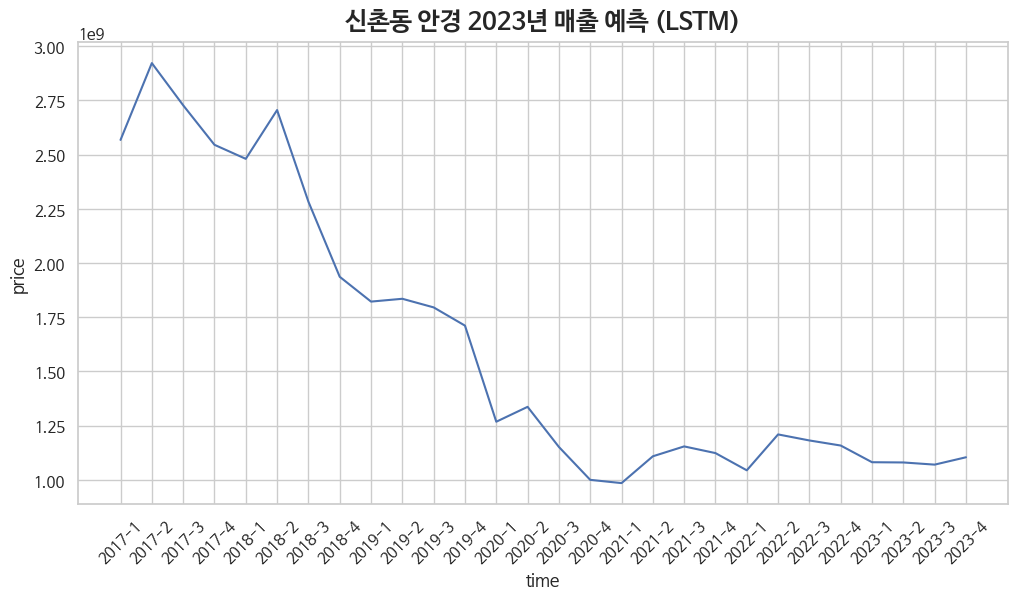

In [ ]:
### seaborn lineplot을 이용, 전체 매출 시각화

# 시각화에 필요한 matplotlib.pyplot, seaborn 라이브러리 임폴트
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화

sns.set(style="whitegrid", color_codes=True, font='NanumBarunGothic')

plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['분기당_매출_금액'])
plt.title('신촌동 안경 2023년 매출 예측 (LSTM)', fontsize = 18, fontweight='bold', pad =10)
plt.xlabel('time')
plt.xticks(rotation=45)
plt.ylabel('price')
plt.show()

## 23년 1분기 매출 예측

In [ ]:
### X / y 데이터 생성
X = sin_glasses[['성장성', '시장성', '순점포증감률']]
y = sin_glasses.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  2.832336e+05  7.317073
1   1.137986  6.938791e+05  2.380952
2   0.933478  3.055805e+06 -2.439024
3   0.933119  6.319227e+06 -5.128205
4   0.974559  3.277822e+06 -2.631579
5   1.090700  4.986376e+06 -5.555556
6   0.843879  8.629945e+05  2.702703
7   0.848209  1.577374e+06 -5.714286
8   0.940879  8.395642e+05  0.000000
9   1.007123 -4.877256e+06  0.000000
10  0.978365 -1.234306e+06  5.405405
11  0.953169  2.604515e+06 -5.714286
12  0.740986 -3.655992e+06  0.000000
13  1.054100 -7.492285e+06  0.000000
14  0.861594 -5.429903e+06 -2.941176
15  0.868239 -6.532915e+06  0.000000
16  0.984977 -5.635899e+06 -3.030303
17  1.125560 -5.540562e+06  3.125000
18  1.041129 -6.148390e+06  0.000000
19  0.973286 -1.030818e+07  0.000000
20  0.929313 -1.210676e+07 -3.030303
21  1.158581 -1.230288e+07 -3.125000
22  0.976956 -1.123506e+07 -3.225806
23  0.980189 -7.236307e+06  0.000000
---------------------------------------------------------------------------

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [ ]:
### 시계열 분석에 적합한 데이터를 만들어 주는 함수 정의
def make_dataset(X, y, window_size=10):
    X_data = []
    y_data = []
    for start in np.arange(len(X) - window_size):
        stop = start + window_size
        X_data.append(X[start:stop, :])
        y_data.append(y[stop])
    return np.array(X_data), np.array(y_data)




### 시계열 분석에서 마지막 테스트 데이터를 만들어 주는 함수 정의
def make_last_dataset(X, window_size=10):
    X_data_last = []
    for start in np.arange(len(X) - window_size +1):
        stop = start + window_size
        X_data_last.append(X[start:stop, :])
    return X_data_last[-1]

In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [ ]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.56506792 0.05734168 0.19096084]
 [0.57281029 0.27207303 0.43850267]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (17, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (17, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (17, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (17, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
# model.compile(loss='mean_squared_error', optimizer='adam')

model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### 모델 학습

# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4000
Epoch 1: val_loss improved from inf to 0.00508, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.4000 - val_loss: 0.0051
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3849
Epoch 2: val_loss improved from 0.00508 to 0.00394, saving model to stock_model.h5
1/1 [==============================] - 0s 122ms/step - loss: 0.3849 - val_loss: 0.0039
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3705
Epoch 3: val_loss improved from 0.00394 to 0.00302, saving model to stock_model.h5
1/1 [==============================] - 0s 114ms/step - loss: 0.3705 - val_loss: 0.0030
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3565
Epoch 4: val_loss improved from 0.00302 to 0.00231, saving model to stock_model.h5
1/1 [==============================] - 0s 113ms/step - loss: 0.3565 - val_loss: 0.0023
Epoch 5/100
1/1 [==============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 852ms/step
[[0.06028799]
 [0.05461564]
 [0.05055145]
 [0.04963994]
 [0.05288874]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2021-4,0.071454,0.060288
2022-1,0.030467,0.054616
2022-2,0.115919,0.050551
2022-3,0.101532,0.049640
2022-4,0.089449,0.052889


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_glasses의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2021-4,0.071454,0.060288,1123433428,1.101799e+09,21634004.0
2022-1,0.030467,0.054616,1044021337,1.090809e+09,-46788135.0
2022-2,0.115919,0.050551,1209583283,1.082935e+09,126648115.0
2022-3,0.101532,0.049640,1181709062,1.081169e+09,100539910.0
2022-4,0.089449,0.052889,1158297861,1.087464e+09,70834309.0


### 결과

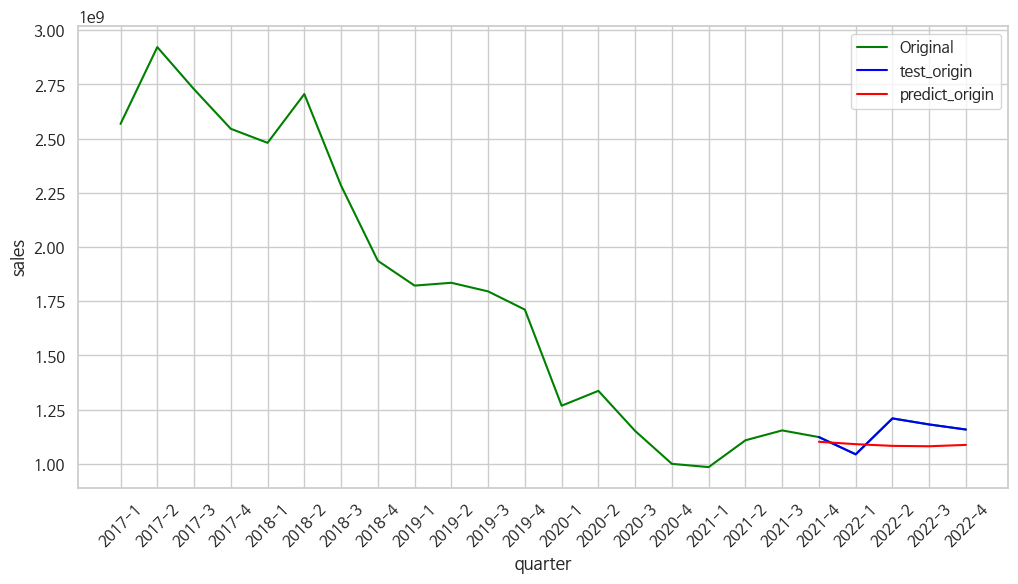

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean     5.457364e+07
std      6.879547e+07
min     -4.678814e+07
25%      2.163400e+07
50%      7.083431e+07
75%      1.005399e+08
max      1.266481e+08
dtype: float64

In [ ]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 22ms/step
[[0.04972479]]
--------------------------------------------------------------------------------
예측된 매출  : 1081333504.0 


## 23년 1분기 성장성 예측

In [ ]:
# 성장을 예측하기 위한 지표로는 성장성, 안정성, 시장성, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_glasses[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_glasses.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

     분기당_매출_금액           시장성    순점포증감률
0   2568100921  2.832336e+05  7.317073
1   2922462753  6.938791e+05  2.380952
2   2728055739  3.055805e+06 -2.439024
3   2545599522  6.319227e+06 -5.128205
4   2480836170  3.277822e+06 -2.631579
5   2705848282  4.986376e+06 -5.555556
6   2283408344  8.629945e+05  2.702703
7   1936807781  1.577374e+06 -5.714286
8   1822302180  8.395642e+05  0.000000
9   1835282683 -4.877256e+06  0.000000
10  1795576052 -1.234306e+06  5.405405
11  1711488130  2.604515e+06 -5.714286
12  1268188661 -3.655992e+06  0.000000
13  1336797234 -7.492285e+06  0.000000
14  1151776461 -5.429903e+06 -2.941176
15  1000016761 -6.532915e+06  0.000000
16   984993272 -5.635899e+06 -3.030303
17  1108669138 -5.540562e+06  3.125000
18  1154268135 -6.148390e+06  0.000000
19  1123433428 -1.030818e+07  0.000000
20  1044021337 -1.210676e+07 -3.030303
21  1209583283 -1.230288e+07 -3.125000
22  1181709062 -1.123506e+07 -3.225806
23  1158297861 -7.236307e+06  0.000000
-------------------------

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [ ]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [ ]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.10153233 0.05734168 0.19096084]
 [0.08944894 0.27207303 0.43850267]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (17, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (17, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (17, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (17, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3157
Epoch 1: val_loss improved from inf to 0.38702, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.3157 - val_loss: 0.3870
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3023
Epoch 2: val_loss improved from 0.38702 to 0.37721, saving model to stock_model.h5
1/1 [==============================] - 0s 103ms/step - loss: 0.3023 - val_loss: 0.3772
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2894
Epoch 3: val_loss improved from 0.37721 to 0.36767, saving model to stock_model.h5
1/1 [==============================] - 0s 76ms/step - loss: 0.2894 - val_loss: 0.3677
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2771
Epoch 4: val_loss improved from 0.36767 to 0.35840, saving model to stock_model.h5
1/1 [==============================] - 0s 88ms/step - loss: 0.2771 - val_loss: 0.3584
Epoch 5/100
1/1 [================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 803ms/step
[[0.39579734]
 [0.35321918]
 [0.29978186]
 [0.26215616]
 [0.27246925]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2021-4,0.556282,0.395797
2022-1,0.450980,0.353219
2022-2,1.000000,0.299782
2022-3,0.565068,0.262156
2022-4,0.572810,0.272469


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 3].values       # 성장성이 sin_glasses의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2021-4,0.556282,0.395797,0.973286,0.906269,0.067017
2022-1,0.450980,0.353219,0.929313,0.888489,0.040825
2022-2,1.000000,0.299782,1.158581,0.866173,0.292408
2022-3,0.565068,0.262156,0.976956,0.850461,0.126494
2022-4,0.572810,0.272469,0.980189,0.854768,0.125421


### 결과

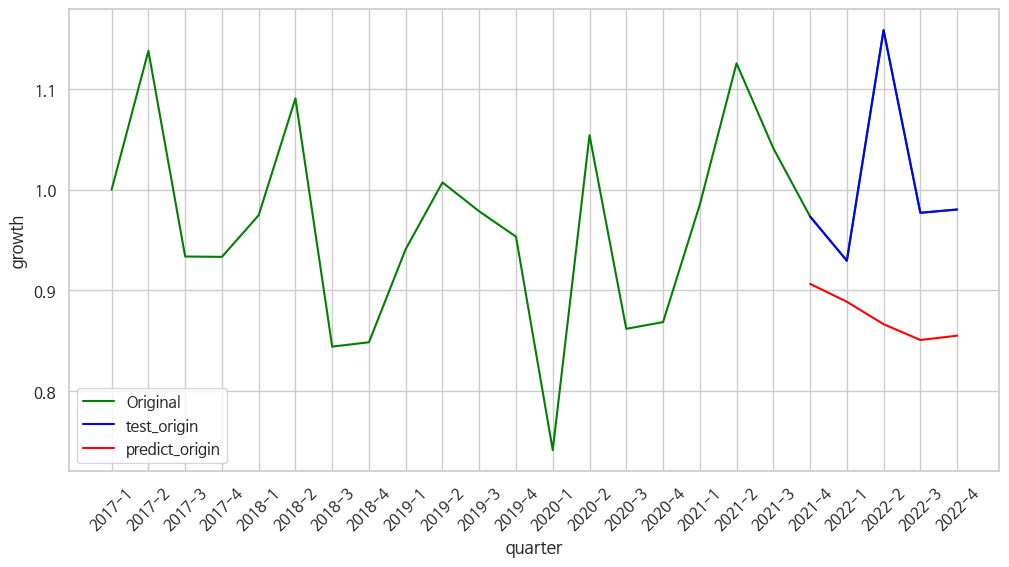

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [ ]:
## error의 요약 통계량
error.describe()

count    5.000000
mean     0.130433
std      0.097887
min      0.040825
25%      0.067017
50%      0.125421
75%      0.126494
max      0.292408
dtype: float64

In [ ]:
### 23년 1분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 25ms/step
[[0.30408618]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8679708242416382 


## 23년 1분기 시장성 예측

In [ ]:
# 시장성을 예측하기 위한 지표로는 성장성, 안정성, 총매출, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_glasses[['성장성', '분기당_매출_금액', '순점포증감률']]
y = sin_glasses.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성   분기당_매출_금액    순점포증감률
0   1.000000  2568100921  7.317073
1   1.137986  2922462753  2.380952
2   0.933478  2728055739 -2.439024
3   0.933119  2545599522 -5.128205
4   0.974559  2480836170 -2.631579
5   1.090700  2705848282 -5.555556
6   0.843879  2283408344  2.702703
7   0.848209  1936807781 -5.714286
8   0.940879  1822302180  0.000000
9   1.007123  1835282683  0.000000
10  0.978365  1795576052  5.405405
11  0.953169  1711488130 -5.714286
12  0.740986  1268188661  0.000000
13  1.054100  1336797234  0.000000
14  0.861594  1151776461 -2.941176
15  0.868239  1000016761  0.000000
16  0.984977   984993272 -3.030303
17  1.125560  1108669138  3.125000
18  1.041129  1154268135  0.000000
19  0.973286  1123433428  0.000000
20  0.929313  1044021337 -3.030303
21  1.158581  1209583283 -3.125000
22  0.976956  1181709062 -3.225806
23  0.980189  1158297861  0.000000
--------------------------------------------------------------------------------
             시장성
0   2.832336e+05
1   6.9387

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [ ]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [ ]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.56506792 0.10153233 0.19096084]
 [0.57281029 0.08944894 0.43850267]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (17, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (17, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (17, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (17, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5696
Epoch 1: val_loss improved from inf to 0.12126, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.5696 - val_loss: 0.1213
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5512
Epoch 2: val_loss improved from 0.12126 to 0.11516, saving model to stock_model.h5
1/1 [==============================] - 0s 137ms/step - loss: 0.5512 - val_loss: 0.1152
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.5335
Epoch 3: val_loss improved from 0.11516 to 0.10930, saving model to stock_model.h5
1/1 [==============================] - 0s 109ms/step - loss: 0.5335 - val_loss: 0.1093
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.5163
Epoch 4: val_loss improved from 0.10930 to 0.10366, saving model to stock_model.h5
1/1 [==============================] - 0s 100ms/step - loss: 0.5163 - val_loss: 0.1037
Epoch 5/100
1/1 [==============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 804ms/step
[[0.44235507]
 [0.38523844]
 [0.3434522 ]
 [0.33462495]
 [0.3774092 ]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2021-4,0.107114,0.442355
2022-1,0.010532,0.385238
2022-2,0.000000,0.343452
2022-3,0.057342,0.334625
2022-4,0.272073,0.377409


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 5].values       # 시장성이 sin_glasses의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2021-4,0.107114,0.442355,-1.030818e+07,-4065297.0,-6.242888e+06
2022-1,0.010532,0.385238,-1.210676e+07,-5128928.5,-6.977830e+06
2022-2,0.000000,0.343452,-1.230288e+07,-5907076.5,-6.395804e+06
2022-3,0.057342,0.334625,-1.123506e+07,-6071458.5,-5.163599e+06
2022-4,0.272073,0.377409,-7.236307e+06,-5274725.5,-1.961582e+06


### 결과

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


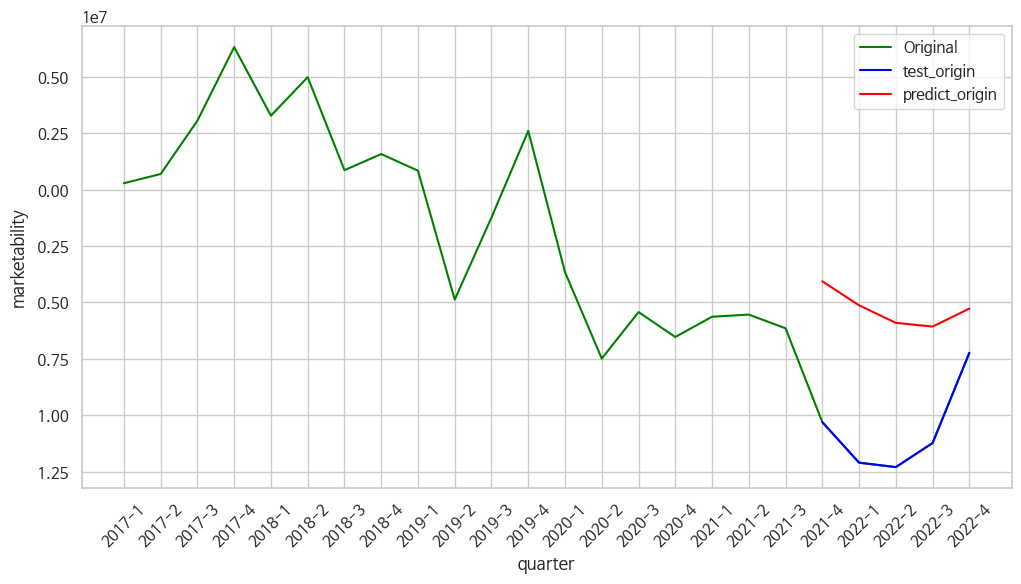

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean    -5.348340e+06
std      2.003553e+06
min     -6.977830e+06
25%     -6.395804e+06
50%     -6.242888e+06
75%     -5.163599e+06
max     -1.961582e+06
dtype: float64

In [ ]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 22ms/step
[[0.34352127]]
--------------------------------------------------------------------------------
예측된 시장성  : -5905790.5 


## 23년 1분기 순점포증감률 예측

In [ ]:
# 순점포증감률을 예측하기 위한 지표로는 성장성, 안정성, 총매출, 시장성 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_glasses[['성장성', '분기당_매출_금액', '시장성']]
y = sin_glasses.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성   분기당_매출_금액           시장성
0   1.000000  2568100921  2.832336e+05
1   1.137986  2922462753  6.938791e+05
2   0.933478  2728055739  3.055805e+06
3   0.933119  2545599522  6.319227e+06
4   0.974559  2480836170  3.277822e+06
5   1.090700  2705848282  4.986376e+06
6   0.843879  2283408344  8.629945e+05
7   0.848209  1936807781  1.577374e+06
8   0.940879  1822302180  8.395642e+05
9   1.007123  1835282683 -4.877256e+06
10  0.978365  1795576052 -1.234306e+06
11  0.953169  1711488130  2.604515e+06
12  0.740986  1268188661 -3.655992e+06
13  1.054100  1336797234 -7.492285e+06
14  0.861594  1151776461 -5.429903e+06
15  0.868239  1000016761 -6.532915e+06
16  0.984977   984993272 -5.635899e+06
17  1.125560  1108669138 -5.540562e+06
18  1.041129  1154268135 -6.148390e+06
19  0.973286  1123433428 -1.030818e+07
20  0.929313  1044021337 -1.210676e+07
21  1.158581  1209583283 -1.230288e+07
22  0.976956  1181709062 -1.123506e+07
23  0.980189  1158297861 -7.236307e+06
-------------------------

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [ ]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [ ]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.56506792 0.10153233 0.05734168]
 [0.57281029 0.08944894 0.27207303]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (17, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (17, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (17, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (17, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.1917
Epoch 1: val_loss improved from inf to 0.18707, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.1917 - val_loss: 0.1871
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1823
Epoch 2: val_loss improved from 0.18707 to 0.17999, saving model to stock_model.h5
1/1 [==============================] - 0s 98ms/step - loss: 0.1823 - val_loss: 0.1800
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1734
Epoch 3: val_loss improved from 0.17999 to 0.17313, saving model to stock_model.h5
1/1 [==============================] - 0s 88ms/step - loss: 0.1734 - val_loss: 0.1731
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1649
Epoch 4: val_loss improved from 0.17313 to 0.16648, saving model to stock_model.h5
1/1 [==============================] - 0s 122ms/step - loss: 0.1649 - val_loss: 0.1665
Epoch 5/100
1/1 [================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 809ms/step
[[0.2852753 ]
 [0.25221837]
 [0.20751068]
 [0.2060233 ]
 [0.22738293]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2021-4,0.438503,0.285275
2022-1,0.205963,0.252218
2022-2,0.198697,0.207511
2022-3,0.190961,0.206023
2022-4,0.438503,0.227383


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_glasses의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2021-4,0.438503,0.285275,0.000000,-1.996761,1.996761
2022-1,0.205963,0.252218,-3.030303,-2.427538,-0.602765
2022-2,0.198697,0.207511,-3.125000,-3.010139,-0.114861
2022-3,0.190961,0.206023,-3.225806,-3.029522,-0.196285
2022-4,0.438503,0.227383,0.000000,-2.751177,2.751177


### 결과

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


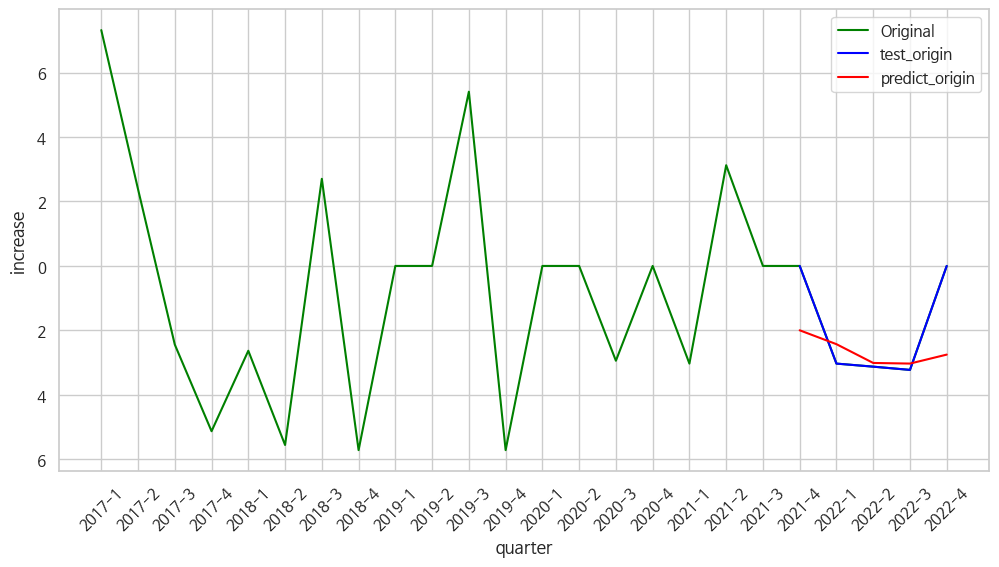

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000
mean     0.766805
std      1.502591
min     -0.602765
25%     -0.196285
50%     -0.114861
75%      1.996761
max      2.751177
dtype: float64

In [ ]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 25ms/step
[[0.22399938]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -2.795269250869751 


## 원본 데이터에 예측값 추가하기

In [ ]:
print(sales)
print(growth)
print(marketability)
print(increase)

1081333500.0
0.8679708
-5905790.5
-2.7952693


In [ ]:
sin_glasses.loc[24] = ['2023-1', '안경', sales, growth, increase, marketability]

<ipython-input-69-4b4261a1e82c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_glasses.loc[24] = ['2023-1', '안경', sales, growth, increase, marketability]


In [ ]:
sin_glasses

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,안경,2.568101e+09,1.000000,7.317073,2.832336e+05
1,2017-2,안경,2.922463e+09,1.137986,2.380952,6.938791e+05
2,2017-3,안경,2.728056e+09,0.933478,-2.439024,3.055805e+06
3,2017-4,안경,2.545600e+09,0.933119,-5.128205,6.319227e+06
4,2018-1,안경,2.480836e+09,0.974559,-2.631579,3.277822e+06
5,2018-2,안경,2.705848e+09,1.090700,-5.555556,4.986376e+06
6,2018-3,안경,2.283408e+09,0.843879,2.702703,8.629945e+05
7,2018-4,안경,1.936808e+09,0.848209,-5.714286,1.577374e+06
8,2019-1,안경,1.822302e+09,0.940879,0.000000,8.395642e+05
9,2019-2,안경,1.835283e+09,1.007123,0.000000,-4.877256e+06


## 23년 2분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본 데이터에 추가

### 매출

In [ ]:
################ 매출 ####################

# 총 매출액을 예측하기 위한 지표로는 성장성, 시장성, 순점포증감률 선정.

### X / y 데이터 생성
X = sin_glasses[['성장성', '시장성', '순점포증감률']]
y = sin_glasses.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  2.832336e+05  7.317073
1   1.137986  6.938791e+05  2.380952
2   0.933478  3.055805e+06 -2.439024
3   0.933119  6.319227e+06 -5.128205
4   0.974559  3.277822e+06 -2.631579
5   1.090700  4.986376e+06 -5.555556
6   0.843879  8.629945e+05  2.702703
7   0.848209  1.577374e+06 -5.714286
8   0.940879  8.395642e+05  0.000000
9   1.007123 -4.877256e+06  0.000000
10  0.978365 -1.234306e+06  5.405405
11  0.953169  2.604515e+06 -5.714286
12  0.740986 -3.655992e+06  0.000000
13  1.054100 -7.492285e+06  0.000000
14  0.861594 -5.429903e+06 -2.941176
15  0.868239 -6.532915e+06  0.000000
16  0.984977 -5.635899e+06 -3.030303
17  1.125560 -5.540562e+06  3.125000
18  1.041129 -6.148390e+06  0.000000
19  0.973286 -1.030818e+07  0.000000
20  0.929313 -1.210676e+07 -3.030303
21  1.158581 -1.230288e+07 -3.125000
22  0.976956 -1.123506e+07 -3.225806
23  0.980189 -7.236307e+06  0.000000
24  0.867971 -5.905790e+06 -2.795269
--------------------------------------

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [ ]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.57281029 0.27207303 0.43850267]
 [0.30408616 0.34352127 0.22399939]]


In [ ]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3702
Epoch 1: val_loss improved from inf to 0.00459, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.3702 - val_loss: 0.0046
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3561
Epoch 2: val_loss improved from 0.00459 to 0.00343, saving model to stock_model.h5
1/1 [==============================] - 0s 95ms/step - loss: 0.3561 - val_loss: 0.0034
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3426
Epoch 3: val_loss improved from 0.00343 to 0.00251, saving model to stock_model.h5
1/1 [==============================] - 0s 97ms/step - loss: 0.3426 - val_loss: 0.0025
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3295
Epoch 4: val_loss improved from 0.00251 to 0.00182, saving model to stock_model.h5
1/1 [==============================] - 0s 87ms/step - loss: 0.3295 - val_loss: 0.0018
Epoch 5/100
1/1 [=================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.05464462]
 [0.0505833 ]
 [0.04968857]
 [0.05293438]
 [0.04975224]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.030467,0.054645
2022-2,0.115919,0.050583
2022-3,0.101532,0.049689
2022-4,0.089449,0.052934
2023-1,0.049725,0.049752


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_glasses의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.030467,0.054645,1.044021e+09,1.090866e+09,-46844199.0
2022-2,0.115919,0.050583,1.209583e+09,1.082997e+09,126586419.0
2022-3,0.101532,0.049689,1.181709e+09,1.081263e+09,100445702.0
2022-4,0.089449,0.052934,1.158298e+09,1.087552e+09,70745861.0
2023-1,0.049725,0.049752,1.081334e+09,1.081387e+09,-53120.0


In [ ]:
df_test = df_test.reset_index()

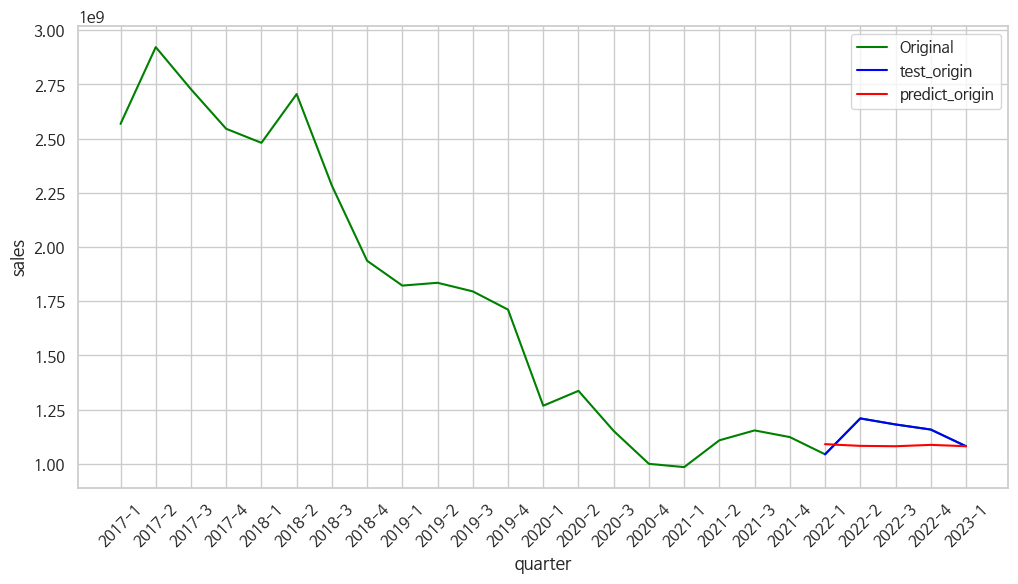

In [ ]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean     5.017613e+07
std      7.198020e+07
min     -4.684420e+07
25%     -5.312000e+04
50%      7.074586e+07
75%      1.004457e+08
max      1.265864e+08
dtype: float64

In [ ]:
### 23년 2분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 23ms/step
[[0.04915843]]
--------------------------------------------------------------------------------
예측된 매출  : 1080236288.0 


### 성장성

In [ ]:
### X / y 데이터 생성
X = sin_glasses[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_glasses.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   2.568101e+09  2.832336e+05  7.317073
1   2.922463e+09  6.938791e+05  2.380952
2   2.728056e+09  3.055805e+06 -2.439024
3   2.545600e+09  6.319227e+06 -5.128205
4   2.480836e+09  3.277822e+06 -2.631579
5   2.705848e+09  4.986376e+06 -5.555556
6   2.283408e+09  8.629945e+05  2.702703
7   1.936808e+09  1.577374e+06 -5.714286
8   1.822302e+09  8.395642e+05  0.000000
9   1.835283e+09 -4.877256e+06  0.000000
10  1.795576e+09 -1.234306e+06  5.405405
11  1.711488e+09  2.604515e+06 -5.714286
12  1.268189e+09 -3.655992e+06  0.000000
13  1.336797e+09 -7.492285e+06  0.000000
14  1.151776e+09 -5.429903e+06 -2.941176
15  1.000017e+09 -6.532915e+06  0.000000
16  9.849933e+08 -5.635899e+06 -3.030303
17  1.108669e+09 -5.540562e+06  3.125000
18  1.154268e+09 -6.148390e+06  0.000000
19  1.123433e+09 -1.030818e+07  0.000000
20  1.044021e+09 -1.210676e+07 -3.030303
21  1.209583e+09 -1.230288e+07 -3.125000
22  1.181709e+09 -1.123506e+07 -3.225806
23  1.158298e+09

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [ ]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.08944894 0.27207303 0.43850267]
 [0.04972477 0.34352127 0.22399939]]


In [ ]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2988
Epoch 1: val_loss improved from inf to 0.43333, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.2988 - val_loss: 0.4333
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2860
Epoch 2: val_loss improved from 0.43333 to 0.42245, saving model to stock_model.h5
1/1 [==============================] - 0s 96ms/step - loss: 0.2860 - val_loss: 0.4225
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2736
Epoch 3: val_loss improved from 0.42245 to 0.41187, saving model to stock_model.h5
1/1 [==============================] - 0s 98ms/step - loss: 0.2736 - val_loss: 0.4119
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2618
Epoch 4: val_loss improved from 0.41187 to 0.40157, saving model to stock_model.h5
1/1 [==============================] - 0s 104ms/step - loss: 0.2618 - val_loss: 0.4016
Epoch 5/100
1/1 [================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.35169947]
 [0.29841334]
 [0.26073736]
 [0.27095914]
 [0.30253765]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.450980,0.351699
2022-2,1.000000,0.298413
2022-3,0.565068,0.260737
2022-4,0.572810,0.270959
2023-1,0.304086,0.302538


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 3].values       # 성장성이 sin_glasses의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.450980,0.351699,0.929313,0.887854,0.041459
2022-2,1.000000,0.298413,1.158581,0.865602,0.292979
2022-3,0.565068,0.260737,0.976956,0.849869,0.127087
2022-4,0.572810,0.270959,0.980189,0.854137,0.126052
2023-1,0.304086,0.302538,0.867971,0.867324,0.000647


In [ ]:
df_test = df_test.reset_index()

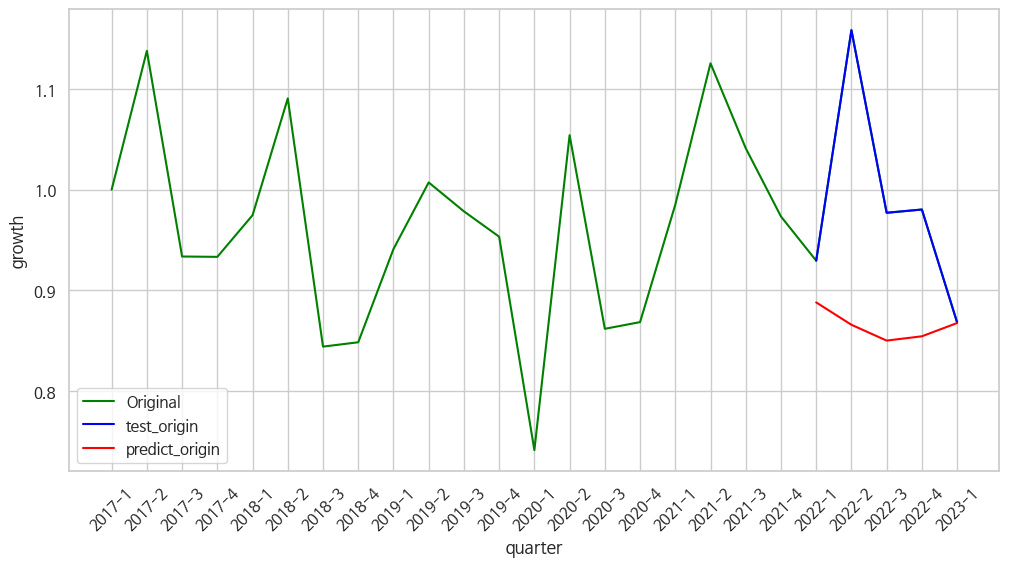

In [ ]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000
mean     0.117645
std      0.112244
min      0.000647
25%      0.041459
50%      0.126052
75%      0.127087
max      0.292979
dtype: float64

In [ ]:
### 23년 2분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 22ms/step
[[0.3444955]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8848455548286438 


### 시장성

In [ ]:
### X / y 데이터 생성
X = sin_glasses[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_glasses.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   2.568101e+09  1.000000  7.317073
1   2.922463e+09  1.137986  2.380952
2   2.728056e+09  0.933478 -2.439024
3   2.545600e+09  0.933119 -5.128205
4   2.480836e+09  0.974559 -2.631579
5   2.705848e+09  1.090700 -5.555556
6   2.283408e+09  0.843879  2.702703
7   1.936808e+09  0.848209 -5.714286
8   1.822302e+09  0.940879  0.000000
9   1.835283e+09  1.007123  0.000000
10  1.795576e+09  0.978365  5.405405
11  1.711488e+09  0.953169 -5.714286
12  1.268189e+09  0.740986  0.000000
13  1.336797e+09  1.054100  0.000000
14  1.151776e+09  0.861594 -2.941176
15  1.000017e+09  0.868239  0.000000
16  9.849933e+08  0.984977 -3.030303
17  1.108669e+09  1.125560  3.125000
18  1.154268e+09  1.041129  0.000000
19  1.123433e+09  0.973286  0.000000
20  1.044021e+09  0.929313 -3.030303
21  1.209583e+09  1.158581 -3.125000
22  1.181709e+09  0.976956 -3.225806
23  1.158298e+09  0.980189  0.000000
24  1.081334e+09  0.867971 -2.795269
--------------------------------------

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [ ]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.08944894 0.57281029 0.43850267]
 [0.04972477 0.30408616 0.22399939]]


In [ ]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5311
Epoch 1: val_loss improved from inf to 0.10509, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.5311 - val_loss: 0.1051
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5138
Epoch 2: val_loss improved from 0.10509 to 0.09943, saving model to stock_model.h5
1/1 [==============================] - 0s 105ms/step - loss: 0.5138 - val_loss: 0.0994
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.4971
Epoch 3: val_loss improved from 0.09943 to 0.09399, saving model to stock_model.h5
1/1 [==============================] - 0s 84ms/step - loss: 0.4971 - val_loss: 0.0940
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.4810
Epoch 4: val_loss improved from 0.09399 to 0.08877, saving model to stock_model.h5
1/1 [==============================] - 0s 90ms/step - loss: 0.4810 - val_loss: 0.0888
Epoch 5/100
1/1 [================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.29406732]
 [0.2655104 ]
 [0.25405928]
 [0.2811752 ]
 [0.2655996 ]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.010532,0.294067
2022-2,0.000000,0.265510
2022-3,0.057342,0.254059
2022-4,0.272073,0.281175
2023-1,0.343521,0.265600


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 5].values       # 시장성이 sin_glasses의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.010532,0.294067,-1.210676e+07,-6826727.0,-5.280031e+06
2022-2,0.000000,0.265510,-1.230288e+07,-7358517.0,-4.944363e+06
2022-3,0.057342,0.254059,-1.123506e+07,-7571761.0,-3.663297e+06
2022-4,0.272073,0.281175,-7.236307e+06,-7066805.5,-1.695018e+05
2023-1,0.343521,0.265600,-5.905790e+06,-7356855.5,1.451065e+06


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


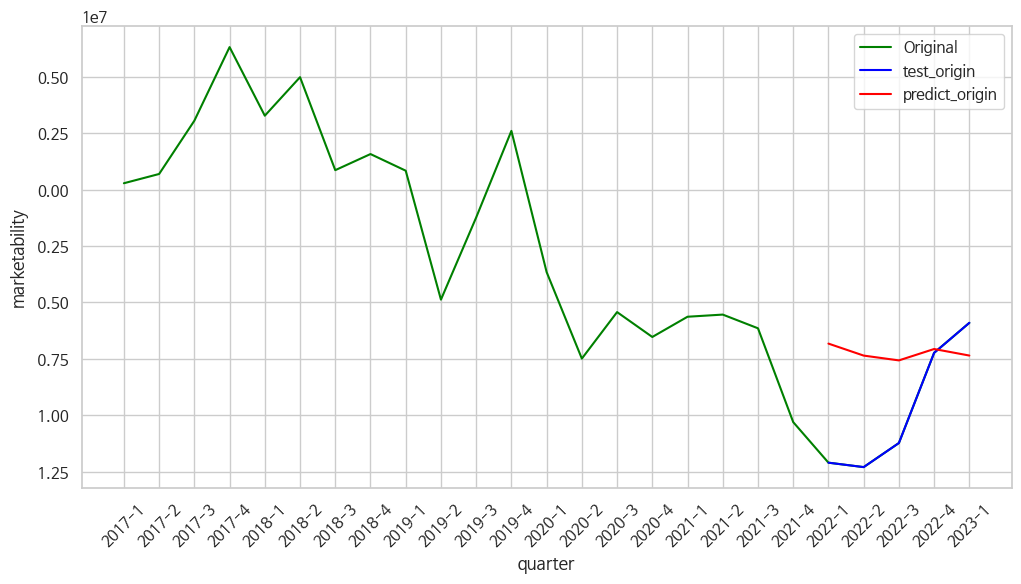

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean    -2.521226e+06
std      3.004023e+06
min     -5.280031e+06
25%     -4.944363e+06
50%     -3.663297e+06
75%     -1.695018e+05
max      1.451065e+06
dtype: float64

In [ ]:
### 23년 2분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 32ms/step
[[0.26624042]]
--------------------------------------------------------------------------------
예측된 시장성  : -7344922.5 


### 순점포증감률

In [ ]:
### X / y 데이터 생성
X = sin_glasses[['분기당_매출_금액', '성장성', '시장성']]
y = sin_glasses.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   2.568101e+09  1.000000  2.832336e+05
1   2.922463e+09  1.137986  6.938791e+05
2   2.728056e+09  0.933478  3.055805e+06
3   2.545600e+09  0.933119  6.319227e+06
4   2.480836e+09  0.974559  3.277822e+06
5   2.705848e+09  1.090700  4.986376e+06
6   2.283408e+09  0.843879  8.629945e+05
7   1.936808e+09  0.848209  1.577374e+06
8   1.822302e+09  0.940879  8.395642e+05
9   1.835283e+09  1.007123 -4.877256e+06
10  1.795576e+09  0.978365 -1.234306e+06
11  1.711488e+09  0.953169  2.604515e+06
12  1.268189e+09  0.740986 -3.655992e+06
13  1.336797e+09  1.054100 -7.492285e+06
14  1.151776e+09  0.861594 -5.429903e+06
15  1.000017e+09  0.868239 -6.532915e+06
16  9.849933e+08  0.984977 -5.635899e+06
17  1.108669e+09  1.125560 -5.540562e+06
18  1.154268e+09  1.041129 -6.148390e+06
19  1.123433e+09  0.973286 -1.030818e+07
20  1.044021e+09  0.929313 -1.210676e+07
21  1.209583e+09  1.158581 -1.230288e+07
22  1.181709e+09  0.976956 -1.123506e+07
23  1.158298e+09

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [ ]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.08944894 0.57281029 0.27207303]
 [0.04972477 0.30408616 0.34352127]]


In [ ]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.1794
Epoch 1: val_loss improved from inf to 0.23188, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.1794 - val_loss: 0.2319
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1705
Epoch 2: val_loss improved from 0.23188 to 0.22311, saving model to stock_model.h5
1/1 [==============================] - 0s 84ms/step - loss: 0.1705 - val_loss: 0.2231
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1621
Epoch 3: val_loss improved from 0.22311 to 0.21462, saving model to stock_model.h5
1/1 [==============================] - 0s 84ms/step - loss: 0.1621 - val_loss: 0.2146
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1541
Epoch 4: val_loss improved from 0.21462 to 0.20639, saving model to stock_model.h5
1/1 [==============================] - 0s 88ms/step - loss: 0.1541 - val_loss: 0.2064
Epoch 5/100
1/1 [=================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.23167601]
 [0.19077152]
 [0.18554536]
 [0.20221636]
 [0.20686081]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.205963,0.231676
2022-2,0.198697,0.190772
2022-3,0.190961,0.185545
2022-4,0.438503,0.202216
2023-1,0.223999,0.206861


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_glasses의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.205963,0.231676,-3.030303,-2.695232,-0.335071
2022-2,0.198697,0.190772,-3.125000,-3.228274,0.103274
2022-3,0.190961,0.185545,-3.225806,-3.296378,0.070571
2022-4,0.438503,0.202216,0.000000,-3.079132,3.079132
2023-1,0.223999,0.206861,-2.795269,-3.018608,0.223339


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


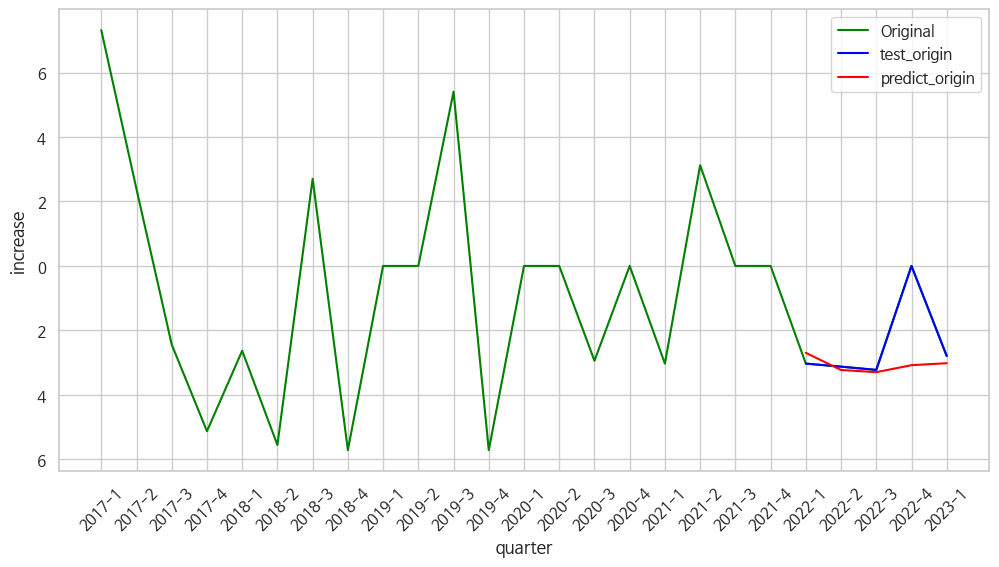

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000
mean     0.628249
std      1.386125
min     -0.335071
25%      0.070571
50%      0.103274
75%      0.223339
max      3.079132
dtype: float64

In [ ]:
### 23년 2분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 34ms/step
[[0.22996199]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -2.7175683975219727 


### 추가


In [ ]:
sin_glasses.loc[25] = ['2023-2', '안경', sales, growth, increase, marketability]

<ipython-input-121-a851681d00ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_glasses.loc[25] = ['2023-2', '안경', sales, growth, increase, marketability]


In [ ]:
sin_glasses

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,안경,2.568101e+09,1.000000,7.317073,2.832336e+05
1,2017-2,안경,2.922463e+09,1.137986,2.380952,6.938791e+05
2,2017-3,안경,2.728056e+09,0.933478,-2.439024,3.055805e+06
3,2017-4,안경,2.545600e+09,0.933119,-5.128205,6.319227e+06
4,2018-1,안경,2.480836e+09,0.974559,-2.631579,3.277822e+06
5,2018-2,안경,2.705848e+09,1.090700,-5.555556,4.986376e+06
6,2018-3,안경,2.283408e+09,0.843879,2.702703,8.629945e+05
7,2018-4,안경,1.936808e+09,0.848209,-5.714286,1.577374e+06
8,2019-1,안경,1.822302e+09,0.940879,0.000000,8.395642e+05
9,2019-2,안경,1.835283e+09,1.007123,0.000000,-4.877256e+06


## 23년 3분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본 데이터에 추가

### 매출

In [ ]:
################ 매출 ####################

### X / y 데이터 생성
X = sin_glasses[['성장성', '시장성', '순점포증감률']]
y = sin_glasses.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  2.832336e+05  7.317073
1   1.137986  6.938791e+05  2.380952
2   0.933478  3.055805e+06 -2.439024
3   0.933119  6.319227e+06 -5.128205
4   0.974559  3.277822e+06 -2.631579
5   1.090700  4.986376e+06 -5.555556
6   0.843879  8.629945e+05  2.702703
7   0.848209  1.577374e+06 -5.714286
8   0.940879  8.395642e+05  0.000000
9   1.007123 -4.877256e+06  0.000000
10  0.978365 -1.234306e+06  5.405405
11  0.953169  2.604515e+06 -5.714286
12  0.740986 -3.655992e+06  0.000000
13  1.054100 -7.492285e+06  0.000000
14  0.861594 -5.429903e+06 -2.941176
15  0.868239 -6.532915e+06  0.000000
16  0.984977 -5.635899e+06 -3.030303
17  1.125560 -5.540562e+06  3.125000
18  1.041129 -6.148390e+06  0.000000
19  0.973286 -1.030818e+07  0.000000
20  0.929313 -1.210676e+07 -3.030303
21  1.158581 -1.230288e+07 -3.125000
22  0.976956 -1.123506e+07 -3.225806
23  0.980189 -7.236307e+06  0.000000
24  0.867971 -5.905790e+06 -2.795269
25  0.884846 -7.344922e+06 -2.717568
-

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.30408616 0.34352127 0.22399939]
 [0.34449547 0.26624043 0.229962  ]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3438
Epoch 1: val_loss improved from inf to 0.00482, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.3438 - val_loss: 0.0048
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3307
Epoch 2: val_loss improved from 0.00482 to 0.00357, saving model to stock_model.h5
1/1 [==============================] - 0s 87ms/step - loss: 0.3307 - val_loss: 0.0036
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3181
Epoch 3: val_loss improved from 0.00357 to 0.00257, saving model to stock_model.h5
1/1 [==============================] - 0s 85ms/step - loss: 0.3181 - val_loss: 0.0026
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3060
Epoch 4: val_loss improved from 0.00257 to 0.00180, saving model to stock_model.h5
1/1 [==============================] - 0s 85ms/step - loss: 0.3060 - val_loss: 0.0018
Epoch 5/100
1/1 [=================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 781ms/step
[[0.05058264]
 [0.04969384]
 [0.05294191]
 [0.04975001]
 [0.04914609]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.115919,0.050583
2022-3,0.101532,0.049694
2022-4,0.089449,0.052942
2023-1,0.049725,0.049750
2023-2,0.049158,0.049146


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_glasses의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.115919,0.050583,1.209583e+09,1.082996e+09,126587699.0
2022-3,0.101532,0.049694,1.181709e+09,1.081274e+09,100435462.0
2022-4,0.089449,0.052942,1.158298e+09,1.087567e+09,70731269.0
2023-1,0.049725,0.049750,1.081334e+09,1.081382e+09,-48896.0
2023-2,0.049158,0.049146,1.080236e+09,1.080212e+09,23936.0


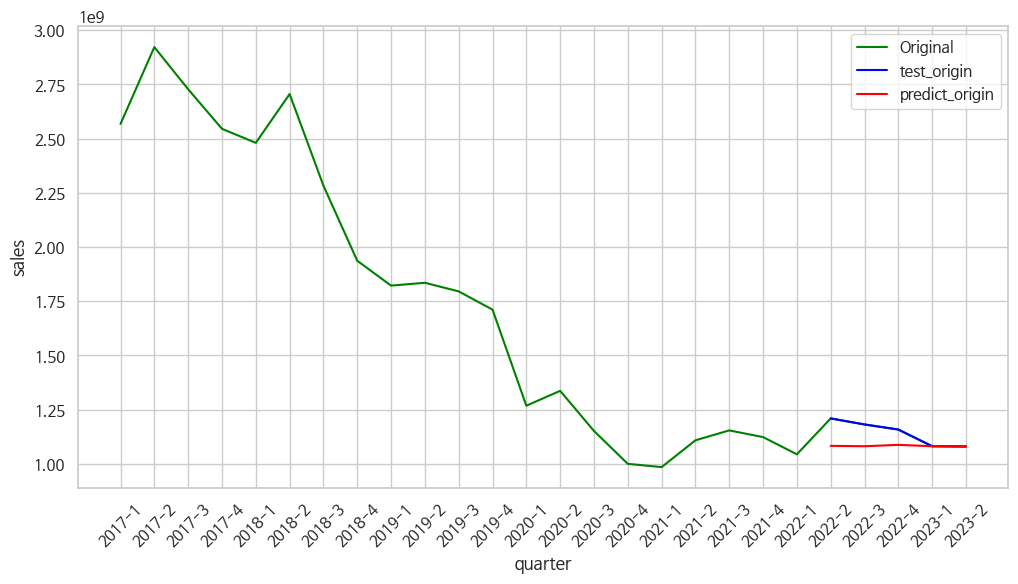

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean     5.954589e+07
std      5.784910e+07
min     -4.889600e+04
25%      2.393600e+04
50%      7.073127e+07
75%      1.004355e+08
max      1.265877e+08
dtype: float64

In [ ]:
### 23년 3분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 23ms/step
[[0.04400421]]
--------------------------------------------------------------------------------
예측된 매출  : 1070250048.0 


### 성장성

In [ ]:
X = sin_glasses[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_glasses.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   2.568101e+09  2.832336e+05  7.317073
1   2.922463e+09  6.938791e+05  2.380952
2   2.728056e+09  3.055805e+06 -2.439024
3   2.545600e+09  6.319227e+06 -5.128205
4   2.480836e+09  3.277822e+06 -2.631579
5   2.705848e+09  4.986376e+06 -5.555556
6   2.283408e+09  8.629945e+05  2.702703
7   1.936808e+09  1.577374e+06 -5.714286
8   1.822302e+09  8.395642e+05  0.000000
9   1.835283e+09 -4.877256e+06  0.000000
10  1.795576e+09 -1.234306e+06  5.405405
11  1.711488e+09  2.604515e+06 -5.714286
12  1.268189e+09 -3.655992e+06  0.000000
13  1.336797e+09 -7.492285e+06  0.000000
14  1.151776e+09 -5.429903e+06 -2.941176
15  1.000017e+09 -6.532915e+06  0.000000
16  9.849933e+08 -5.635899e+06 -3.030303
17  1.108669e+09 -5.540562e+06  3.125000
18  1.154268e+09 -6.148390e+06  0.000000
19  1.123433e+09 -1.030818e+07  0.000000
20  1.044021e+09 -1.210676e+07 -3.030303
21  1.209583e+09 -1.230288e+07 -3.125000
22  1.181709e+09 -1.123506e+07 -3.225806
23  1.158298e+09

In [ ]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.04972477 0.34352127 0.22399939]
 [0.04915846 0.26624043 0.229962  ]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2849
Epoch 1: val_loss improved from inf to 0.45549, saving model to stock_model.h5
1/1 [==============================] - 9s 9s/step - loss: 0.2849 - val_loss: 0.4555
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2725
Epoch 2: val_loss improved from 0.45549 to 0.44413, saving model to stock_model.h5
1/1 [==============================] - 0s 102ms/step - loss: 0.2725 - val_loss: 0.4441
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2607
Epoch 3: val_loss improved from 0.44413 to 0.43308, saving model to stock_model.h5
1/1 [==============================] - 0s 115ms/step - loss: 0.2607 - val_loss: 0.4331
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2494
Epoch 4: val_loss improved from 0.43308 to 0.42230, saving model to stock_model.h5
1/1 [==============================] - 0s 96ms/step - loss: 0.2494 - val_loss: 0.4223
Epoch 5/100
1/1 [===============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.29902872]
 [0.2610054 ]
 [0.2711849 ]
 [0.30287144]
 [0.3450616 ]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,1.000000,0.299029
2022-3,0.565068,0.261005
2022-4,0.572810,0.271185
2023-1,0.304086,0.302871
2023-2,0.344495,0.345062


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 3].values       # 성장성이 sin_glasses의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,1.000000,0.299029,1.158581,0.865859,0.292722
2022-3,0.565068,0.261005,0.976956,0.849980,0.126975
2022-4,0.572810,0.271185,0.980189,0.854231,0.125957
2023-1,0.304086,0.302871,0.867971,0.867464,0.000507
2023-2,0.344495,0.345062,0.884846,0.885082,-0.000236


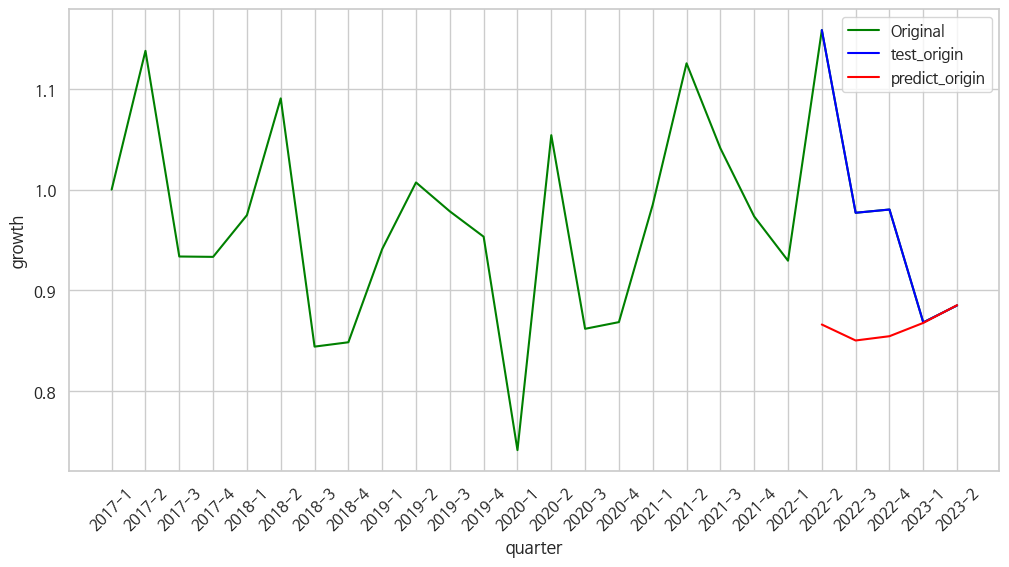

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000
mean     0.109185
std      0.120486
min     -0.000236
25%      0.000507
50%      0.125957
75%      0.126975
max      0.292722
dtype: float64

In [ ]:
### 23년 3분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 22ms/step
[[0.32132325]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8751689791679382 


### 시장성

In [ ]:
### X / y 데이터 생성
X = sin_glasses[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_glasses.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   2.568101e+09  1.000000  7.317073
1   2.922463e+09  1.137986  2.380952
2   2.728056e+09  0.933478 -2.439024
3   2.545600e+09  0.933119 -5.128205
4   2.480836e+09  0.974559 -2.631579
5   2.705848e+09  1.090700 -5.555556
6   2.283408e+09  0.843879  2.702703
7   1.936808e+09  0.848209 -5.714286
8   1.822302e+09  0.940879  0.000000
9   1.835283e+09  1.007123  0.000000
10  1.795576e+09  0.978365  5.405405
11  1.711488e+09  0.953169 -5.714286
12  1.268189e+09  0.740986  0.000000
13  1.336797e+09  1.054100  0.000000
14  1.151776e+09  0.861594 -2.941176
15  1.000017e+09  0.868239  0.000000
16  9.849933e+08  0.984977 -3.030303
17  1.108669e+09  1.125560  3.125000
18  1.154268e+09  1.041129  0.000000
19  1.123433e+09  0.973286  0.000000
20  1.044021e+09  0.929313 -3.030303
21  1.209583e+09  1.158581 -3.125000
22  1.181709e+09  0.976956 -3.225806
23  1.158298e+09  0.980189  0.000000
24  1.081334e+09  0.867971 -2.795269
25  1.080236e+09  0.884846 -2.717568
-

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.04972477 0.30408616 0.22399939]
 [0.04915846 0.34449547 0.229962  ]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_21 (LSTM)              (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5013
Epoch 1: val_loss improved from inf to 0.08379, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.5013 - val_loss: 0.0838
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4848
Epoch 2: val_loss improved from 0.08379 to 0.07922, saving model to stock_model.h5
1/1 [==============================] - 0s 92ms/step - loss: 0.4848 - val_loss: 0.0792
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.4688
Epoch 3: val_loss improved from 0.07922 to 0.07487, saving model to stock_model.h5
1/1 [==============================] - 0s 86ms/step - loss: 0.4688 - val_loss: 0.0749
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.4534
Epoch 4: val_loss improved from 0.07487 to 0.07076, saving model to stock_model.h5
1/1 [==============================] - 0s 90ms/step - loss: 0.4534 - val_loss: 0.0708
Epoch 5/100
1/1 [=================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 790ms/step
[[0.20294443]
 [0.19425142]
 [0.21317351]
 [0.20312425]
 [0.20357084]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.000000,0.202944
2022-3,0.057342,0.194251
2022-4,0.272073,0.213174
2023-1,0.343521,0.203124
2023-2,0.266240,0.203571


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 5].values       # 시장성이 sin_glasses의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.000000,0.202944,-1.230288e+07,-8523627.0,-3.779253e+06
2022-3,0.057342,0.194251,-1.123506e+07,-8685509.0,-2.549549e+06
2022-4,0.272073,0.213174,-7.236307e+06,-8333140.0,1.096833e+06
2023-1,0.343521,0.203124,-5.905790e+06,-8520278.0,2.614488e+06
2023-2,0.266240,0.203571,-7.344922e+06,-8511962.0,1.167040e+06


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


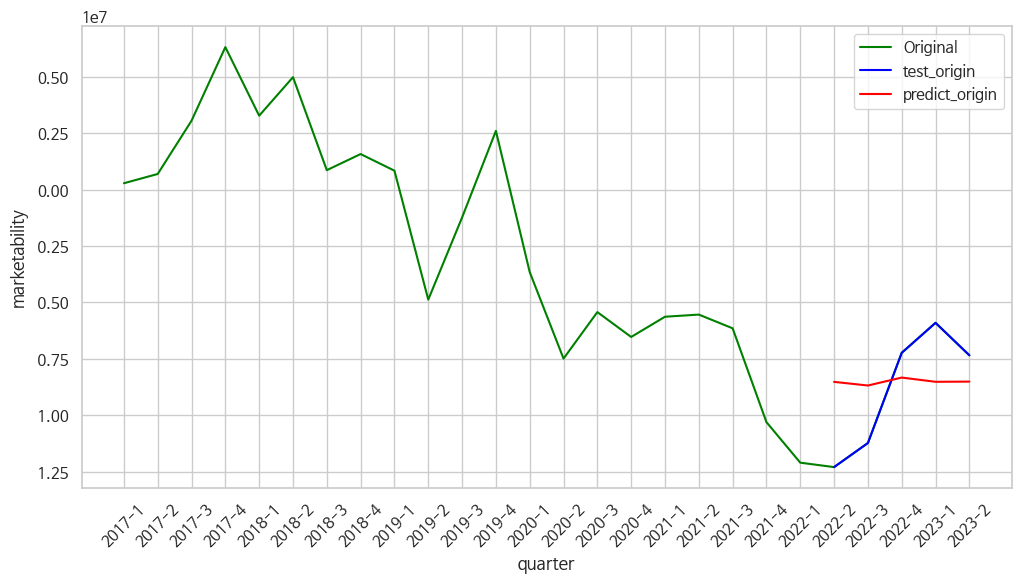

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean    -2.900884e+05
std      2.727763e+06
min     -3.779253e+06
25%     -2.549549e+06
50%      1.096833e+06
75%      1.167040e+06
max      2.614488e+06
dtype: float64

In [ ]:
### 23년 3분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 33ms/step
[[0.17630687]]
--------------------------------------------------------------------------------
예측된 시장성  : -9019675.0 


### 순점포증감률

In [ ]:
### X / y 데이터 생성
X = sin_glasses[['분기당_매출_금액', '성장성', '시장성']]
y = sin_glasses.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   2.568101e+09  1.000000  2.832336e+05
1   2.922463e+09  1.137986  6.938791e+05
2   2.728056e+09  0.933478  3.055805e+06
3   2.545600e+09  0.933119  6.319227e+06
4   2.480836e+09  0.974559  3.277822e+06
5   2.705848e+09  1.090700  4.986376e+06
6   2.283408e+09  0.843879  8.629945e+05
7   1.936808e+09  0.848209  1.577374e+06
8   1.822302e+09  0.940879  8.395642e+05
9   1.835283e+09  1.007123 -4.877256e+06
10  1.795576e+09  0.978365 -1.234306e+06
11  1.711488e+09  0.953169  2.604515e+06
12  1.268189e+09  0.740986 -3.655992e+06
13  1.336797e+09  1.054100 -7.492285e+06
14  1.151776e+09  0.861594 -5.429903e+06
15  1.000017e+09  0.868239 -6.532915e+06
16  9.849933e+08  0.984977 -5.635899e+06
17  1.108669e+09  1.125560 -5.540562e+06
18  1.154268e+09  1.041129 -6.148390e+06
19  1.123433e+09  0.973286 -1.030818e+07
20  1.044021e+09  0.929313 -1.210676e+07
21  1.209583e+09  1.158581 -1.230288e+07
22  1.181709e+09  0.976956 -1.123506e+07
23  1.158298e+09

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.04972477 0.30408616 0.34352127]
 [0.04915846 0.34449547 0.26624043]]


In [ ]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_23 (LSTM)              (None, 32)                12416     
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.1821
Epoch 1: val_loss improved from inf to 0.20060, saving model to stock_model.h5
1/1 [==============================] - 7s 7s/step - loss: 0.1821 - val_loss: 0.2006
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1732
Epoch 2: val_loss improved from 0.20060 to 0.19274, saving model to stock_model.h5
1/1 [==============================] - 0s 95ms/step - loss: 0.1732 - val_loss: 0.1927
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1647
Epoch 3: val_loss improved from 0.19274 to 0.18514, saving model to stock_model.h5
1/1 [==============================] - 0s 101ms/step - loss: 0.1647 - val_loss: 0.1851
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1567
Epoch 4: val_loss improved from 0.18514 to 0.17779, saving model to stock_model.h5
1/1 [==============================] - 0s 101ms/step - loss: 0.1567 - val_loss: 0.1778
Epoch 5/100
1/1 [===============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 770ms/step
[[0.20386238]
 [0.20027669]
 [0.2200192 ]
 [0.22042786]
 [0.2422135 ]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.198697,0.203862
2022-3,0.190961,0.200277
2022-4,0.438503,0.220019
2023-1,0.223999,0.220428
2023-2,0.229962,0.242214


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_glasses의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.198697,0.203862,-3.125000,-3.057682,-0.067318
2022-3,0.190961,0.200277,-3.225806,-3.104408,-0.121398
2022-4,0.438503,0.220019,0.000000,-2.847136,2.847136
2023-1,0.223999,0.220428,-2.795269,-2.841811,0.046542
2023-2,0.229962,0.242214,-2.717568,-2.557914,-0.159654


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


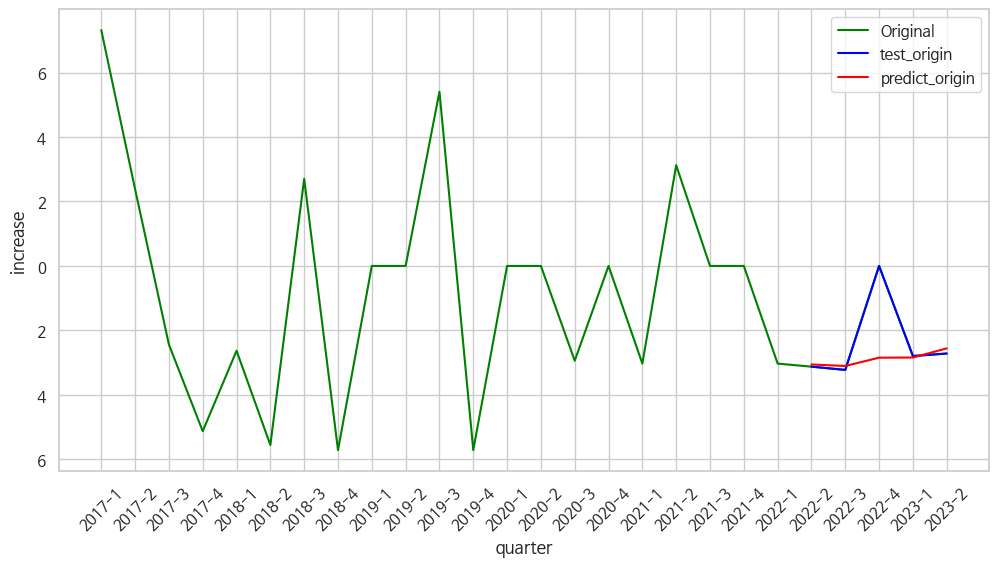

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000
mean     0.509062
std      1.309331
min     -0.159654
25%     -0.121398
50%     -0.067318
75%      0.046542
max      2.847136
dtype: float64

In [ ]:
### 23년 3분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 25ms/step
[[0.23300947]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -2.6778554916381836 


### 추가

In [ ]:
sin_glasses.loc[26] = ['2023-3', '안경', sales, growth, increase, marketability]

<ipython-input-171-35f59e2dccdb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_glasses.loc[26] = ['2023-3', '안경', sales, growth, increase, marketability]


In [ ]:
sin_glasses

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,안경,2.568101e+09,1.000000,7.317073,2.832336e+05
1,2017-2,안경,2.922463e+09,1.137986,2.380952,6.938791e+05
2,2017-3,안경,2.728056e+09,0.933478,-2.439024,3.055805e+06
3,2017-4,안경,2.545600e+09,0.933119,-5.128205,6.319227e+06
4,2018-1,안경,2.480836e+09,0.974559,-2.631579,3.277822e+06
5,2018-2,안경,2.705848e+09,1.090700,-5.555556,4.986376e+06
6,2018-3,안경,2.283408e+09,0.843879,2.702703,8.629945e+05
7,2018-4,안경,1.936808e+09,0.848209,-5.714286,1.577374e+06
8,2019-1,안경,1.822302e+09,0.940879,0.000000,8.395642e+05
9,2019-2,안경,1.835283e+09,1.007123,0.000000,-4.877256e+06


## 23년 4분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본데이터에 추가

### 매출

In [ ]:
### X / y 데이터 생성
X = sin_glasses[['성장성', '시장성', '순점포증감률']]
y = sin_glasses.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  2.832336e+05  7.317073
1   1.137986  6.938791e+05  2.380952
2   0.933478  3.055805e+06 -2.439024
3   0.933119  6.319227e+06 -5.128205
4   0.974559  3.277822e+06 -2.631579
5   1.090700  4.986376e+06 -5.555556
6   0.843879  8.629945e+05  2.702703
7   0.848209  1.577374e+06 -5.714286
8   0.940879  8.395642e+05  0.000000
9   1.007123 -4.877256e+06  0.000000
10  0.978365 -1.234306e+06  5.405405
11  0.953169  2.604515e+06 -5.714286
12  0.740986 -3.655992e+06  0.000000
13  1.054100 -7.492285e+06  0.000000
14  0.861594 -5.429903e+06 -2.941176
15  0.868239 -6.532915e+06  0.000000
16  0.984977 -5.635899e+06 -3.030303
17  1.125560 -5.540562e+06  3.125000
18  1.041129 -6.148390e+06  0.000000
19  0.973286 -1.030818e+07  0.000000
20  0.929313 -1.210676e+07 -3.030303
21  1.158581 -1.230288e+07 -3.125000
22  0.976956 -1.123506e+07 -3.225806
23  0.980189 -7.236307e+06  0.000000
24  0.867971 -5.905790e+06 -2.795269
25  0.884846 -7.344922e+06 -2.717568
2

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.34449547 0.26624043 0.229962  ]
 [0.32132332 0.17630687 0.23300948]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_25 (LSTM)              (None, 32)                12416     
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3209
Epoch 1: val_loss improved from inf to 0.00756, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.3209 - val_loss: 0.0076
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3086
Epoch 2: val_loss improved from 0.00756 to 0.00593, saving model to stock_model.h5
1/1 [==============================] - 0s 102ms/step - loss: 0.3086 - val_loss: 0.0059
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2969
Epoch 3: val_loss improved from 0.00593 to 0.00454, saving model to stock_model.h5
1/1 [==============================] - 0s 97ms/step - loss: 0.2969 - val_loss: 0.0045
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2856
Epoch 4: val_loss improved from 0.00454 to 0.00339, saving model to stock_model.h5
1/1 [==============================] - 0s 101ms/step - loss: 0.2856 - val_loss: 0.0034
Epoch 5/100
1/1 [===============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.06615432]
 [0.07079844]
 [0.06762734]
 [0.06862064]
 [0.06149067]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.101532,0.066154
2022-4,0.089449,0.070798
2023-1,0.049725,0.067627
2023-2,0.049158,0.068621
2023-3,0.044004,0.061491


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_glasses의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.101532,0.066154,1.181709e+09,1.113165e+09,68543878.0
2022-4,0.089449,0.070798,1.158298e+09,1.122163e+09,36134789.0
2023-1,0.049725,0.067627,1.081334e+09,1.116019e+09,-34685696.0
2023-2,0.049158,0.068621,1.080236e+09,1.117944e+09,-37707264.0
2023-3,0.044004,0.061491,1.070250e+09,1.104130e+09,-33879616.0


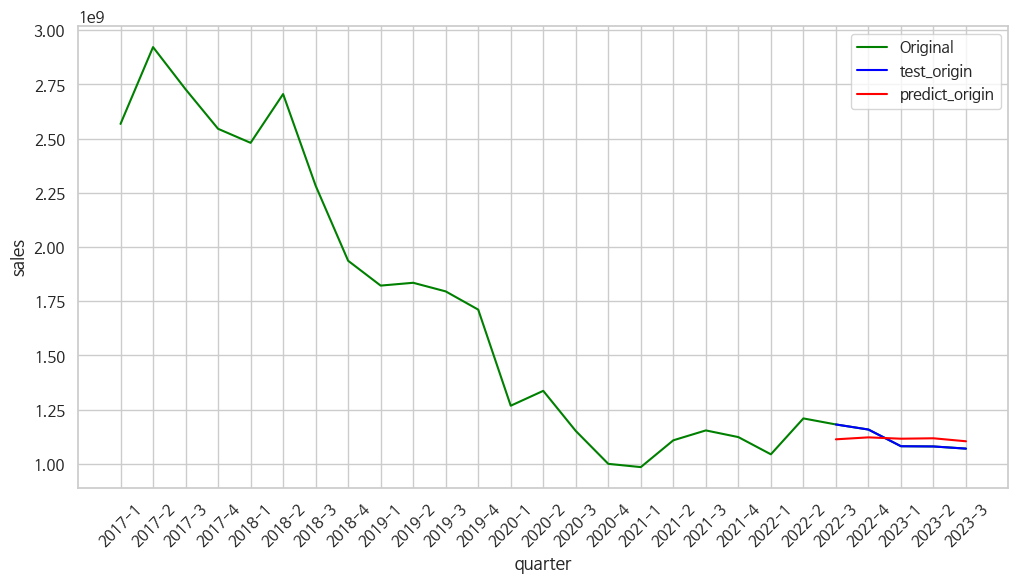

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean    -3.187818e+05
std      4.943744e+07
min     -3.770726e+07
25%     -3.468570e+07
50%     -3.387962e+07
75%      3.613479e+07
max      6.854388e+07
dtype: float64

In [ ]:
### 23년 4분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 22ms/step
[[0.06151282]]
--------------------------------------------------------------------------------
예측된 매출  : 1104172416.0 


### 성장성

In [ ]:
X = sin_glasses[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_glasses.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   2.568101e+09  2.832336e+05  7.317073
1   2.922463e+09  6.938791e+05  2.380952
2   2.728056e+09  3.055805e+06 -2.439024
3   2.545600e+09  6.319227e+06 -5.128205
4   2.480836e+09  3.277822e+06 -2.631579
5   2.705848e+09  4.986376e+06 -5.555556
6   2.283408e+09  8.629945e+05  2.702703
7   1.936808e+09  1.577374e+06 -5.714286
8   1.822302e+09  8.395642e+05  0.000000
9   1.835283e+09 -4.877256e+06  0.000000
10  1.795576e+09 -1.234306e+06  5.405405
11  1.711488e+09  2.604515e+06 -5.714286
12  1.268189e+09 -3.655992e+06  0.000000
13  1.336797e+09 -7.492285e+06  0.000000
14  1.151776e+09 -5.429903e+06 -2.941176
15  1.000017e+09 -6.532915e+06  0.000000
16  9.849933e+08 -5.635899e+06 -3.030303
17  1.108669e+09 -5.540562e+06  3.125000
18  1.154268e+09 -6.148390e+06  0.000000
19  1.123433e+09 -1.030818e+07  0.000000
20  1.044021e+09 -1.210676e+07 -3.030303
21  1.209583e+09 -1.230288e+07 -3.125000
22  1.181709e+09 -1.123506e+07 -3.225806
23  1.158298e+09

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.04915846 0.26624043 0.229962  ]
 [0.04400419 0.17630687 0.23300948]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_27 (LSTM)              (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2900
Epoch 1: val_loss improved from inf to 0.58489, saving model to stock_model.h5
1/1 [==============================] - 10s 10s/step - loss: 0.2900 - val_loss: 0.5849
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2778
Epoch 2: val_loss improved from 0.58489 to 0.57262, saving model to stock_model.h5
1/1 [==============================] - 0s 257ms/step - loss: 0.2778 - val_loss: 0.5726
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2661
Epoch 3: val_loss improved from 0.57262 to 0.56067, saving model to stock_model.h5
1/1 [==============================] - 0s 221ms/step - loss: 0.2661 - val_loss: 0.5607
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2549
Epoch 4: val_loss improved from 0.56067 to 0.54900, saving model to stock_model.h5
1/1 [==============================] - 0s 210ms/step - loss: 0.2549 - val_loss: 0.5490
Epoch 5/100
1/1 [============

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 815ms/step
[[0.26979858]
 [0.27980205]
 [0.31287527]
 [0.35709435]
 [0.33262748]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.565068,0.269799
2022-4,0.572810,0.279802
2023-1,0.304086,0.312875
2023-2,0.344495,0.357094
2023-3,0.321323,0.332627


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 3].values       # 성장성이 sin_glasses의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.565068,0.269799,0.976956,0.853653,0.123303
2022-4,0.572810,0.279802,0.980189,0.857830,0.122359
2023-1,0.304086,0.312875,0.867971,0.871641,-0.003670
2023-2,0.344495,0.357094,0.884846,0.890107,-0.005261
2023-3,0.321323,0.332627,0.875169,0.879890,-0.004721


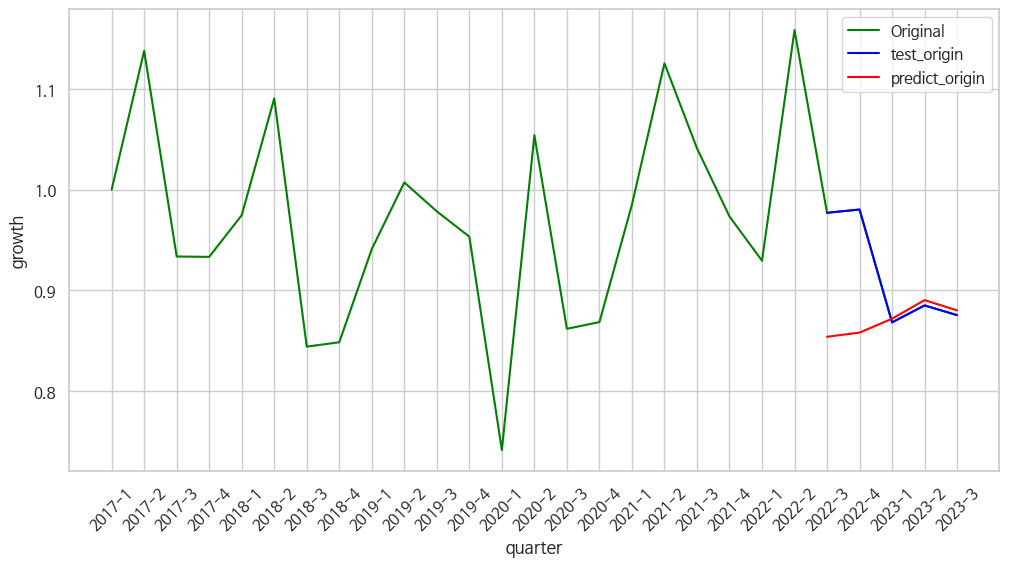

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000
mean     0.046402
std      0.069773
min     -0.005261
25%     -0.004721
50%     -0.003670
75%      0.122359
max      0.123303
dtype: float64

In [ ]:
### 23년 4분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 22ms/step
[[0.31712812]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8734170794487 


###시장성

In [ ]:
### X / y 데이터 생성
X = sin_glasses[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_glasses.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   2.568101e+09  1.000000  7.317073
1   2.922463e+09  1.137986  2.380952
2   2.728056e+09  0.933478 -2.439024
3   2.545600e+09  0.933119 -5.128205
4   2.480836e+09  0.974559 -2.631579
5   2.705848e+09  1.090700 -5.555556
6   2.283408e+09  0.843879  2.702703
7   1.936808e+09  0.848209 -5.714286
8   1.822302e+09  0.940879  0.000000
9   1.835283e+09  1.007123  0.000000
10  1.795576e+09  0.978365  5.405405
11  1.711488e+09  0.953169 -5.714286
12  1.268189e+09  0.740986  0.000000
13  1.336797e+09  1.054100  0.000000
14  1.151776e+09  0.861594 -2.941176
15  1.000017e+09  0.868239  0.000000
16  9.849933e+08  0.984977 -3.030303
17  1.108669e+09  1.125560  3.125000
18  1.154268e+09  1.041129  0.000000
19  1.123433e+09  0.973286  0.000000
20  1.044021e+09  0.929313 -3.030303
21  1.209583e+09  1.158581 -3.125000
22  1.181709e+09  0.976956 -3.225806
23  1.158298e+09  0.980189  0.000000
24  1.081334e+09  0.867971 -2.795269
25  1.080236e+09  0.884846 -2.717568
2

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.04915846 0.34449547 0.229962  ]
 [0.04400419 0.32132332 0.23300948]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4771
Epoch 1: val_loss improved from inf to 0.05705, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.4771 - val_loss: 0.0571
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4613
Epoch 2: val_loss improved from 0.05705 to 0.05356, saving model to stock_model.h5
1/1 [==============================] - 0s 92ms/step - loss: 0.4613 - val_loss: 0.0536
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.4460
Epoch 3: val_loss improved from 0.05356 to 0.05032, saving model to stock_model.h5
1/1 [==============================] - 0s 99ms/step - loss: 0.4460 - val_loss: 0.0503
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.4312
Epoch 4: val_loss improved from 0.05032 to 0.04733, saving model to stock_model.h5
1/1 [==============================] - 0s 88ms/step - loss: 0.4312 - val_loss: 0.0473
Epoch 5/100
1/1 [=================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.1323157 ]
 [0.14353555]
 [0.13902882]
 [0.13975132]
 [0.12258829]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.057342,0.132316
2022-4,0.272073,0.143536
2023-1,0.343521,0.139029
2023-2,0.266240,0.139751
2023-3,0.176307,0.122588


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 5].values       # 시장성이 sin_glasses의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.057342,0.132316,-1.123506e+07,-9838884.0,-1.396174e+06
2022-4,0.272073,0.143536,-7.236307e+06,-9629946.0,2.393639e+06
2023-1,0.343521,0.139029,-5.905790e+06,-9713871.0,3.808080e+06
2023-2,0.266240,0.139751,-7.344922e+06,-9700417.0,2.355494e+06
2023-3,0.176307,0.122588,-9.019675e+06,-10020027.0,1.000352e+06


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


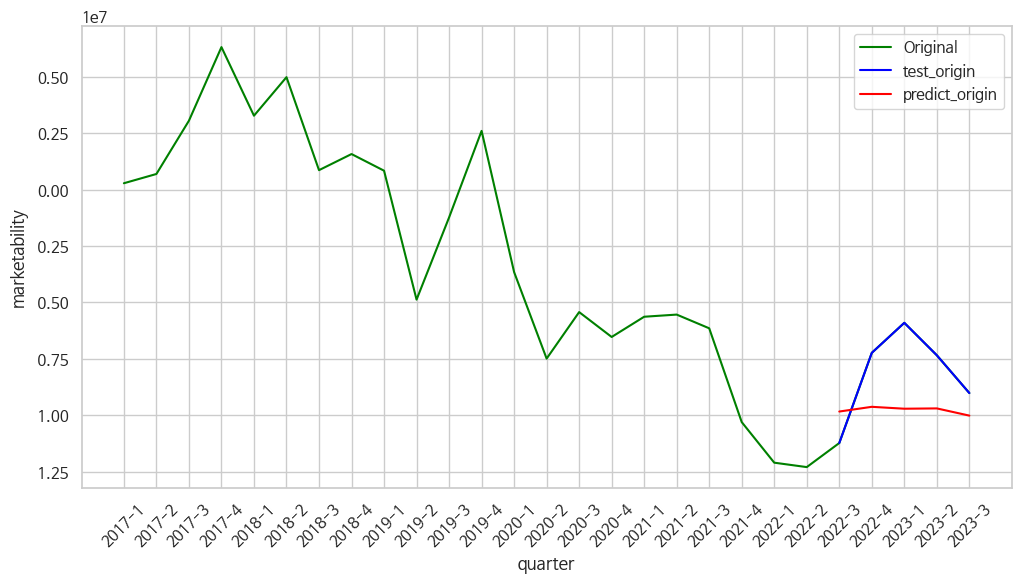

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000e+00
mean     1.632278e+06
std      1.962631e+06
min     -1.396174e+06
25%      1.000352e+06
50%      2.355494e+06
75%      2.393639e+06
max      3.808080e+06
dtype: float64

In [ ]:
### 23년 4분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 47ms/step
[[0.12343848]]
--------------------------------------------------------------------------------
예측된 시장성  : -10004196.0 


### 순점포증감률

In [ ]:
### X / y 데이터 생성
X = sin_glasses[['분기당_매출_금액', '성장성', '시장성']]
y = sin_glasses.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   2.568101e+09  1.000000  2.832336e+05
1   2.922463e+09  1.137986  6.938791e+05
2   2.728056e+09  0.933478  3.055805e+06
3   2.545600e+09  0.933119  6.319227e+06
4   2.480836e+09  0.974559  3.277822e+06
5   2.705848e+09  1.090700  4.986376e+06
6   2.283408e+09  0.843879  8.629945e+05
7   1.936808e+09  0.848209  1.577374e+06
8   1.822302e+09  0.940879  8.395642e+05
9   1.835283e+09  1.007123 -4.877256e+06
10  1.795576e+09  0.978365 -1.234306e+06
11  1.711488e+09  0.953169  2.604515e+06
12  1.268189e+09  0.740986 -3.655992e+06
13  1.336797e+09  1.054100 -7.492285e+06
14  1.151776e+09  0.861594 -5.429903e+06
15  1.000017e+09  0.868239 -6.532915e+06
16  9.849933e+08  0.984977 -5.635899e+06
17  1.108669e+09  1.125560 -5.540562e+06
18  1.154268e+09  1.041129 -6.148390e+06
19  1.123433e+09  0.973286 -1.030818e+07
20  1.044021e+09  0.929313 -1.210676e+07
21  1.209583e+09  1.158581 -1.230288e+07
22  1.181709e+09  0.976956 -1.123506e+07
23  1.158298e+09

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.04915846 0.34449547 0.26624043]
 [0.04400419 0.32132332 0.17630687]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_31 (LSTM)              (None, 32)                12416     
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.1732
Epoch 1: val_loss improved from inf to 0.20059, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.1732 - val_loss: 0.2006
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1647
Epoch 2: val_loss improved from 0.20059 to 0.19278, saving model to stock_model.h5
1/1 [==============================] - 0s 85ms/step - loss: 0.1647 - val_loss: 0.1928
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1565
Epoch 3: val_loss improved from 0.19278 to 0.18524, saving model to stock_model.h5
1/1 [==============================] - 0s 120ms/step - loss: 0.1565 - val_loss: 0.1852
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1489
Epoch 4: val_loss improved from 0.18524 to 0.17794, saving model to stock_model.h5
1/1 [==============================] - 0s 91ms/step - loss: 0.1489 - val_loss: 0.1779
Epoch 5/100
1/1 [================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 822ms/step
[[0.20050627]
 [0.22032504]
 [0.22070861]
 [0.24258888]
 [0.2333473 ]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.190961,0.200506
2022-4,0.438503,0.220325
2023-1,0.223999,0.220709
2023-2,0.229962,0.242589
2023-3,0.233009,0.233347


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_glasses의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.190961,0.200506,-3.225806,-3.101417,-0.124390
2022-4,0.438503,0.220325,0.000000,-2.843151,2.843151
2023-1,0.223999,0.220709,-2.795269,-2.838153,0.042883
2023-2,0.229962,0.242589,-2.717568,-2.553023,-0.164546
2023-3,0.233009,0.233347,-2.677855,-2.673453,-0.004402


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


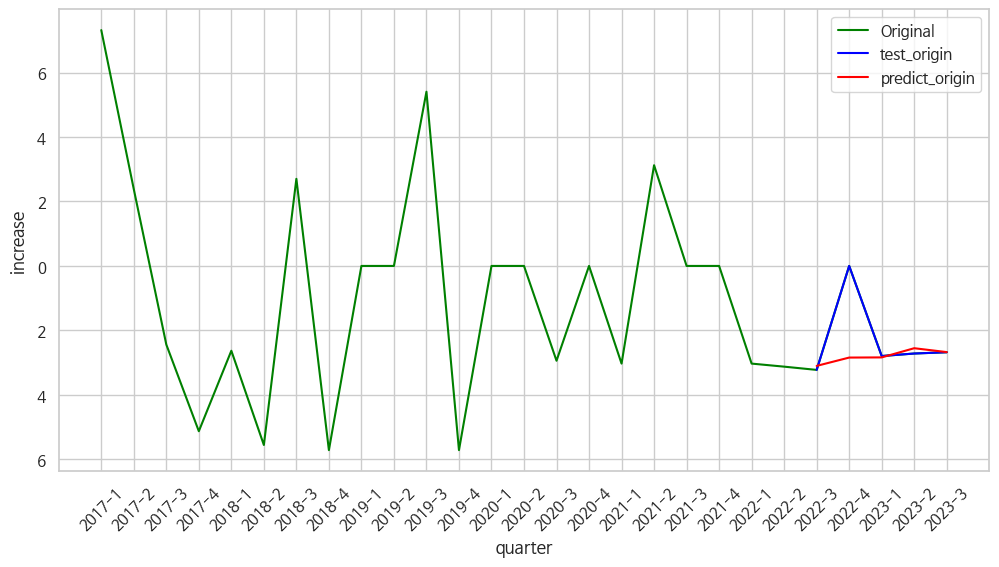

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [ ]:
### error의 요약 통계량
error.describe()

count    5.000000
mean     0.518539
std      1.302258
min     -0.164546
25%     -0.124390
50%     -0.004402
75%      0.042883
max      2.843151
dtype: float64

In [ ]:
### 23년 2분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 22ms/step
[[0.21984068]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -2.8494629859924316 


### 추가

In [ ]:
sin_glasses.loc[27] = ['2023-4', '안경', sales, growth, increase, marketability]

<ipython-input-221-b22600172f71>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_glasses.loc[27] = ['2023-4', '안경', sales, growth, increase, marketability]


In [ ]:
final_sin_glasses = sin_glasses
final_sin_glasses

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,안경,2.568101e+09,1.000000,7.317073,2.832336e+05
1,2017-2,안경,2.922463e+09,1.137986,2.380952,6.938791e+05
2,2017-3,안경,2.728056e+09,0.933478,-2.439024,3.055805e+06
3,2017-4,안경,2.545600e+09,0.933119,-5.128205,6.319227e+06
4,2018-1,안경,2.480836e+09,0.974559,-2.631579,3.277822e+06
5,2018-2,안경,2.705848e+09,1.090700,-5.555556,4.986376e+06
6,2018-3,안경,2.283408e+09,0.843879,2.702703,8.629945e+05
7,2018-4,안경,1.936808e+09,0.848209,-5.714286,1.577374e+06
8,2019-1,안경,1.822302e+09,0.940879,0.000000,8.395642e+05
9,2019-2,안경,1.835283e+09,1.007123,0.000000,-4.877256e+06


## 최종결과

In [ ]:
### X / y 데이터 생성
X = sin_glasses[['성장성', '시장성', '순점포증감률']]
y = sin_glasses.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000  2.832336e+05  7.317073
1   1.137986  6.938791e+05  2.380952
2   0.933478  3.055805e+06 -2.439024
3   0.933119  6.319227e+06 -5.128205
4   0.974559  3.277822e+06 -2.631579
5   1.090700  4.986376e+06 -5.555556
6   0.843879  8.629945e+05  2.702703
7   0.848209  1.577374e+06 -5.714286
8   0.940879  8.395642e+05  0.000000
9   1.007123 -4.877256e+06  0.000000
10  0.978365 -1.234306e+06  5.405405
11  0.953169  2.604515e+06 -5.714286
12  0.740986 -3.655992e+06  0.000000
13  1.054100 -7.492285e+06  0.000000
14  0.861594 -5.429903e+06 -2.941176
15  0.868239 -6.532915e+06  0.000000
16  0.984977 -5.635899e+06 -3.030303
17  1.125560 -5.540562e+06  3.125000
18  1.041129 -6.148390e+06  0.000000
19  0.973286 -1.030818e+07  0.000000
20  0.929313 -1.210676e+07 -3.030303
21  1.158581 -1.230288e+07 -3.125000
22  0.976956 -1.123506e+07 -3.225806
23  0.980189 -7.236307e+06  0.000000
24  0.867971 -5.905790e+06 -2.795269
25  0.884846 -7.344922e+06 -2.717568
2

In [ ]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (28, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (28, 1)


In [ ]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (26, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (26, 1)
[[0.32132332 0.17630687 0.23300948]
 [0.31712811 0.12343847 0.21984067]]


In [ ]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (5, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (5, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (5, 1)


In [ ]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_33 (LSTM)              (None, 32)                12416     
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3209
Epoch 1: val_loss improved from inf to 0.00800, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.3209 - val_loss: 0.0080
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3086
Epoch 2: val_loss improved from 0.00800 to 0.00637, saving model to stock_model.h5
1/1 [==============================] - 0s 81ms/step - loss: 0.3086 - val_loss: 0.0064
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2969
Epoch 3: val_loss improved from 0.00637 to 0.00497, saving model to stock_model.h5
1/1 [==============================] - 0s 89ms/step - loss: 0.2969 - val_loss: 0.0050
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2856
Epoch 4: val_loss improved from 0.00497 to 0.00380, saving model to stock_model.h5
1/1 [==============================] - 0s 91ms/step - loss: 0.2856 - val_loss: 0.0038
Epoch 5/100
1/1 [=================

In [ ]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 799ms/step
[[0.07079844]
 [0.06762734]
 [0.06862064]
 [0.06149067]
 [0.06151282]]


In [ ]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_glasses.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.089449,0.070798
2023-1,0.049725,0.067627
2023-2,0.049158,0.068621
2023-3,0.044004,0.061491
2023-4,0.061513,0.061513


In [ ]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_glasses.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_glasses의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.089449,0.070798,1.158298e+09,1.122163e+09,36134789.0
2023-1,0.049725,0.067627,1.081334e+09,1.116019e+09,-34685696.0
2023-2,0.049158,0.068621,1.080236e+09,1.117944e+09,-37707264.0
2023-3,0.044004,0.061491,1.070250e+09,1.104130e+09,-33879616.0
2023-4,0.061513,0.061513,1.104172e+09,1.104172e+09,0.0


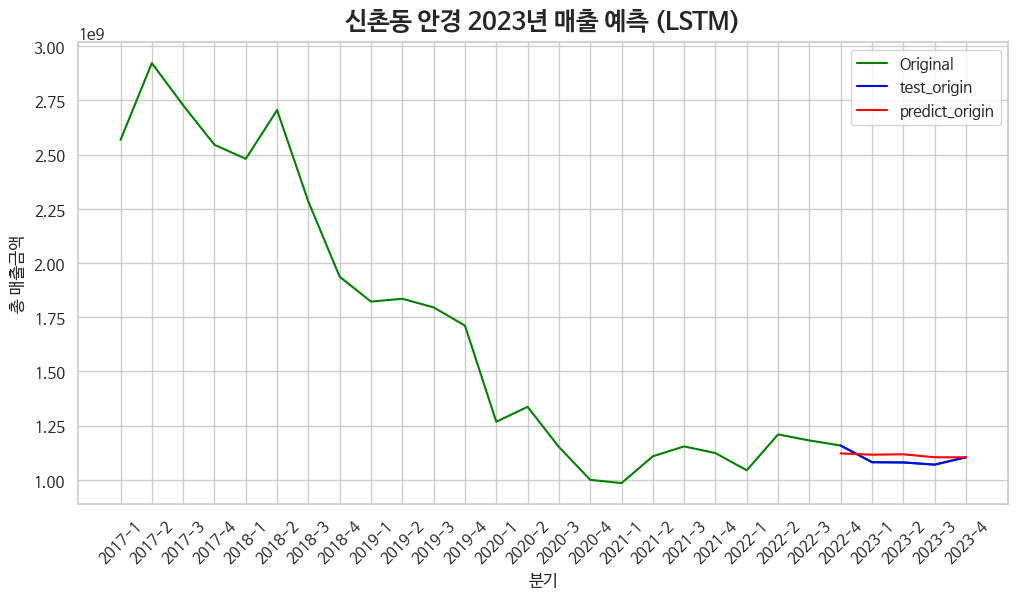

In [ ]:
df_test = df_test.reset_index()

### 결과 시각화

plt.figure(figsize=(12, 6))
plt.plot(sin_glasses['분기'], sin_glasses['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.title('신촌동 안경 2023년 매출 예측 (LSTM)', fontsize = 18, fontweight='bold', pad =10)
plt.xticks(rotation=45)
plt.xlabel('분기')
plt.ylabel('총 매출금액')
plt.legend()
plt.show()